In [1]:
import warnings
from sklearn.utils import compute_class_weight
from sklearn.metrics import confusion_matrix, roc_auc_score, \
                    matthews_corrcoef, ConfusionMatrixDisplay,f1_score, \
                    accuracy_score, recall_score, precision_score, balanced_accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import torch
import torch.nn as nn 
from torch.utils.data import DataLoader, Dataset
from torch.nn import Module, Conv1d, Linear, Dropout, MaxPool1d, functional as F, BatchNorm1d, LazyLinear
from torch.optim import Optimizer
from tqdm import tqdm
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
warnings.filterwarnings("ignore", category=Warning)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
if torch.cuda.is_available():
    torch.cuda.empty_cache()

cuda:0


In [3]:
class CustomDataset(Dataset):
    def __init__(self, x, y):
        super(CustomDataset, self).__init__()
        self.data = torch.from_numpy(x).float()
        self.labels = torch.from_numpy(y).float()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

    def get_labels(self):
        return self.labels

    def get_data(self):
        return self.data


def get_th_dataset(x, y):
    """
    assemble a dataset with the given data and labels
    :param x:
    :param y:
    :return:
    """
    _dataset = CustomDataset(x, y)
    return _dataset


def get_dataloader(dataset: Dataset, batch_size):
    """
    assemble a dataloader with the given dataset
    :param dataset:
    :param batch_size:
    :return:
    """
    _dataLoader = DataLoader(dataset=dataset, batch_size=batch_size, pin_memory=True,
                             drop_last=True, shuffle=True)
    return _dataLoader

In [4]:
class ASLSingleLabel(nn.Module):
    '''
    This loss is intended for single-label classification problems
    '''
    def __init__(self, gamma_pos=0, gamma_neg=4, eps: float = 0.1, reduction='mean'):
        super(ASLSingleLabel, self).__init__()

        self.eps = eps
        self.logsoftmax = nn.LogSoftmax(dim=-1)
        self.targets_classes = []
        self.gamma_pos = gamma_pos
        self.gamma_neg = gamma_neg
        self.reduction = reduction

    def forward(self, inputs, target):
        '''
        "input" dimensions: - (batch_size,number_classes)
        "target" dimensions: - (batch_size)
        '''
        num_classes = inputs.size()[-1]
        log_preds = self.logsoftmax(inputs)
        self.targets_classes = torch.zeros_like(inputs).scatter_(1, target.long().unsqueeze(1), 1)

        # ASL weights
        targets = self.targets_classes
        anti_targets = 1 - targets
        xs_pos = torch.exp(log_preds)
        xs_neg = 1 - xs_pos
        xs_pos = xs_pos * targets
        xs_neg = xs_neg * anti_targets
        asymmetric_w = torch.pow(1 - xs_pos - xs_neg,
                                 self.gamma_pos * targets + self.gamma_neg * anti_targets)
        log_preds = log_preds * asymmetric_w

        if self.eps > 0:  # label smoothing
            self.targets_classes = self.targets_classes.mul(1 - self.eps).add(self.eps / num_classes)

        # loss calculation
        loss = - self.targets_classes.mul(log_preds)

        loss = loss.sum(dim=-1)
        if self.reduction == 'mean':
            loss = loss.mean()

        return loss

In [5]:
class Cnn(Module):
    """
    CNN model
    """
    def __init__(self, kernel_size=3, output_dim=1, input_dim=320, drop_out=0, stride=2, padding=1):
        super(Cnn, self).__init__()
        self.output_dim = output_dim
        self.input_dim = input_dim
        self.drop_out = drop_out
        self.padding = padding

        self.kernel_1 = kernel_size
        self.channel_1 = 32

        self.conv_1 = Conv1d(kernel_size=self.kernel_1, out_channels=self.channel_1, in_channels=1, stride=1, padding=self.padding)
        self.normalizer_1 = BatchNorm1d(self.channel_1)
        self.pooling_1 = MaxPool1d(kernel_size=self.kernel_1, stride=stride)

        self.dropout = Dropout(p=drop_out)
        self.fc1 = LazyLinear(64)
        self.normalizer_2 = BatchNorm1d(64)
        self.fc2 = Linear(64, 2)

    def forward(self, x):
        x = torch.unsqueeze(x, dim=1)  # (batch, embedding_dim) -> (batch, 1, embedding_dim)
        c_1 = self.pooling_1(F.relu(self.normalizer_1(self.conv_1(x))))

        c_2 = torch.flatten(c_1, start_dim=1)
        c_2 = self.dropout(c_2)
        out = F.relu(self.normalizer_2(self.fc1(c_2)))
        out = self.fc2(out)
        out = torch.softmax(out, dim=-1)
        return out

In [6]:
def to_log(epoch: int, loss: float, accuracy, logFile: str, is_append: bool):
    info = str(epoch) + ' ' + str(loss) + ' ' + str(accuracy) + '\n'
    flag = 'a' if is_append else 'w'
    file = open(logFile, flag)  # append mode
    file.write(info)
    file.close()

def scores(y_pred: torch.Tensor, y_test: torch.Tensor):
    predictions = torch.argmax(y_pred, dim=-1).numpy()
    labels = y_test.numpy()
    # labels = th.argmax(y_test, dim=-1).numpy()
    recall = recall_score(y_pred=predictions, y_true=labels, average='binary')
    precision = precision_score(y_pred=predictions, y_true=labels, average='binary')
    f1 = f1_score(y_pred=predictions, y_true=labels, average='binary')
    accuracy = accuracy_score(y_pred=predictions, y_true=labels)
    # auc_score = roc_auc_score(y_score=y_pred.detach().numpy(), y_true=y_test.detach().numpy())
    corr = matthews_corrcoef(y_true=labels, y_pred=predictions)
    balanced_accuracy = balanced_accuracy_score(y_true=labels, y_pred=predictions, )

    report = {
        "recall": recall,
        "precision": precision,
        "f1": f1,
        "accuracy": accuracy,
        # "auc": auc_score,
        'matthews_corrcoef': corr,
        'balanced_accuracy': balanced_accuracy
    }
    return report


def report(model: torch.nn.Module, dataset: CustomDataset):
    _inputs, _labels = dataset.get_data(), dataset.get_labels()
    print(_inputs.size(0))
    predictions = model(_inputs)
    res = scores(predictions, _labels.squeeze())
    print('accuracy ' + str(res["accuracy"]))
    print('precision ' + str(res["precision"]))
    print('f1 ' + str(res["f1"]))
    print('recall ' + str(res["recall"]))
    # print('auc_score ' + str(res["auc"]))
    print('matthews_corrcoef ' + str(res["matthews_corrcoef"]))
    print('balanced_accuracy ' + str(res["balanced_accuracy"]))
    # get_confusion_matrix(predictions, _labels.squeeze())


def train(model: Module, EPOCHS, optimizer: Optimizer, criteria,
           checkpoint, train_set: DataLoader, vali_set: DataLoader, device, LOG_VALIDATION, LOG_TRAIN):
    """
    fine tune the model and save the best model in the checkpoint
    :param LOG_TRAIN:
    :param LOG_VALIDATION:
    :param device:
    :param model: a Cnn or ConvLSTM model
    :param EPOCHS: hyperparameter Epoch
    :param optimizer: pytorch optimizer
    :param criteria: loss function
    :param checkpoint: model checkpoint
    :param train_set: a dataloader
    :param vali_set: a dataloader
    :return: None
    """
    if os.path.exists(LOG_VALIDATION):
        os.remove(LOG_VALIDATION)
    if os.path.exists(LOG_TRAIN):
        os.remove(LOG_TRAIN)
    model = model.to(device)
    min_vali_loss = float("inf")
    for epoch in tqdm(range(EPOCHS)):
        running_loss = 0.0
        train_acc = []
        vali_loss = 0.0
        model.train()
        counter = 0
        for i, (inputs, labels) in enumerate(train_set):
            optimizer.zero_grad()
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            # outputs = outputs.squeeze()
            loss = criteria(outputs.float(), labels.float().squeeze())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            train_acc.append(scores(outputs.to("cpu"), labels.to("cpu"))["accuracy"])
            counter = i
        model.eval()
        acc = 0
        for j, (vali_inputs, vali_labels) in enumerate(vali_set):
            vali_labels = vali_labels.to(device)
            vali_inputs = vali_inputs.to(device)
            vali_outputs = model(vali_inputs)
            # vali_outputs = vali_outputs.squeeze()
            acc = scores(vali_outputs.to('cpu'), vali_labels.to('cpu'))["accuracy"]
            vali_loss = criteria(vali_outputs.to(device).float(), vali_labels.to(device).float().squeeze())
            if vali_loss < min_vali_loss:
                min_vali_loss = vali_loss
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                }, checkpoint)
        avg_loss = running_loss / counter  # loss per batch
        train_accuracy = sum(train_acc) / len(train_acc)
        print('epoch {} train_loss: {} vali_loss: {} test_acc: {}'
              .format(epoch + 1, f'{avg_loss:5f}', f'{vali_loss:5f}', f'{acc: 5f}'))
        # logs
        to_log(epoch, avg_loss, train_accuracy, LOG_TRAIN, True)
        to_log(epoch, vali_loss.item(), acc, LOG_VALIDATION, True)

In [7]:
checkpoint = os.path.join(os.getcwd(), 'cnn.pt')
train_loss_log = os.path.join(os.getcwd(), "cnn_train_log.txt")
test_loss_log = os.path.join(os.getcwd(), "cnn_validation_log.txt")

plot_range = 10000  # range(1, 10000)
stratify = True
batch_size = 16
lr = 0.0001
epochs = 500
weight_decay = 0

df = pd.read_csv('../data/drugfinder/esm2_320_dimensions_with_labels.csv') 
X = df.drop(['label', 'UniProt_id'], axis=1)
y = df['label'].apply(lambda x: 0 if x != 1 else x).to_numpy().astype(np.int64)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scalar = MinMaxScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.fit_transform(X_test)
train_set = get_th_dataset(X_train, y_train)
test_set = get_th_dataset(X_test, y_test)
train_loader = get_dataloader(train_set, batch_size=batch_size)
test_loader = get_dataloader(test_set, batch_size=len(test_set))

In [77]:
model = Cnn(kernel_size=3, output_dim=1, input_dim=320, drop_out=0, stride=2, padding=1)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
criteria = ASLSingleLabel(gamma_pos=1, gamma_neg=1, eps = 0.1)  # find the best hyperparameter

In [78]:
train(model=model, EPOCHS=epochs, optimizer=optimizer, checkpoint=checkpoint, criteria=criteria,
      train_set=train_loader, vali_set=test_loader, device=device, LOG_VALIDATION=test_loss_log, LOG_TRAIN=train_loss_log)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 1/500 [00:00<03:39,  2.27it/s]

epoch 1 train_loss: 0.222717 vali_loss: 0.182526 test_acc:  0.886957


  0%|          | 2/500 [00:00<03:28,  2.38it/s]

epoch 2 train_loss: 0.191182 vali_loss: 0.173255 test_acc:  0.913043


  1%|          | 3/500 [00:01<03:39,  2.27it/s]

epoch 3 train_loss: 0.181184 vali_loss: 0.166590 test_acc:  0.910870


  1%|          | 4/500 [00:01<03:32,  2.33it/s]

epoch 4 train_loss: 0.177207 vali_loss: 0.166648 test_acc:  0.906522


  1%|          | 5/500 [00:02<03:28,  2.38it/s]

epoch 5 train_loss: 0.165855 vali_loss: 0.171064 test_acc:  0.915217


  1%|          | 6/500 [00:02<03:25,  2.40it/s]

epoch 6 train_loss: 0.163207 vali_loss: 0.160049 test_acc:  0.921739


  1%|▏         | 7/500 [00:02<03:20,  2.46it/s]

epoch 7 train_loss: 0.156389 vali_loss: 0.181497 test_acc:  0.873913


  2%|▏         | 8/500 [00:03<03:21,  2.44it/s]

epoch 8 train_loss: 0.153579 vali_loss: 0.192113 test_acc:  0.863043


  2%|▏         | 9/500 [00:03<03:21,  2.43it/s]

epoch 9 train_loss: 0.152172 vali_loss: 0.178110 test_acc:  0.882609


  2%|▏         | 10/500 [00:04<03:18,  2.47it/s]

epoch 10 train_loss: 0.145747 vali_loss: 0.160907 test_acc:  0.908696


  2%|▏         | 11/500 [00:04<03:16,  2.49it/s]

epoch 11 train_loss: 0.141993 vali_loss: 0.185330 test_acc:  0.886957


  2%|▏         | 12/500 [00:04<03:14,  2.50it/s]

epoch 12 train_loss: 0.141210 vali_loss: 0.181901 test_acc:  0.884783


  3%|▎         | 13/500 [00:05<03:16,  2.47it/s]

epoch 13 train_loss: 0.140567 vali_loss: 0.163848 test_acc:  0.919565


  3%|▎         | 14/500 [00:05<03:13,  2.52it/s]

epoch 14 train_loss: 0.136544 vali_loss: 0.180378 test_acc:  0.891304


  3%|▎         | 15/500 [00:06<03:14,  2.49it/s]

epoch 15 train_loss: 0.136702 vali_loss: 0.173080 test_acc:  0.902174


  3%|▎         | 16/500 [00:06<03:13,  2.51it/s]

epoch 16 train_loss: 0.134480 vali_loss: 0.162507 test_acc:  0.910870


  3%|▎         | 17/500 [00:06<03:15,  2.47it/s]

epoch 17 train_loss: 0.131034 vali_loss: 0.169259 test_acc:  0.906522


  4%|▎         | 18/500 [00:07<03:17,  2.44it/s]

epoch 18 train_loss: 0.129130 vali_loss: 0.162396 test_acc:  0.906522


  4%|▍         | 19/500 [00:07<03:17,  2.43it/s]

epoch 19 train_loss: 0.125908 vali_loss: 0.177866 test_acc:  0.895652


  4%|▍         | 20/500 [00:08<03:16,  2.45it/s]

epoch 20 train_loss: 0.124415 vali_loss: 0.163961 test_acc:  0.917391


  4%|▍         | 21/500 [00:08<03:16,  2.43it/s]

epoch 21 train_loss: 0.124650 vali_loss: 0.168629 test_acc:  0.904348


  4%|▍         | 22/500 [00:09<03:17,  2.42it/s]

epoch 22 train_loss: 0.127052 vali_loss: 0.164613 test_acc:  0.902174


  5%|▍         | 23/500 [00:09<03:18,  2.40it/s]

epoch 23 train_loss: 0.125683 vali_loss: 0.166497 test_acc:  0.906522


  5%|▍         | 24/500 [00:09<03:16,  2.42it/s]

epoch 24 train_loss: 0.125569 vali_loss: 0.168776 test_acc:  0.893478


  5%|▌         | 25/500 [00:10<03:16,  2.41it/s]

epoch 25 train_loss: 0.122203 vali_loss: 0.185235 test_acc:  0.871739


  5%|▌         | 26/500 [00:10<03:15,  2.42it/s]

epoch 26 train_loss: 0.120954 vali_loss: 0.165521 test_acc:  0.908696


  5%|▌         | 27/500 [00:11<03:13,  2.44it/s]

epoch 27 train_loss: 0.122721 vali_loss: 0.171406 test_acc:  0.880435


  6%|▌         | 28/500 [00:11<03:10,  2.48it/s]

epoch 28 train_loss: 0.119524 vali_loss: 0.170780 test_acc:  0.900000


  6%|▌         | 29/500 [00:11<03:12,  2.44it/s]

epoch 29 train_loss: 0.117546 vali_loss: 0.172899 test_acc:  0.895652


  6%|▌         | 30/500 [00:12<03:10,  2.47it/s]

epoch 30 train_loss: 0.115335 vali_loss: 0.167526 test_acc:  0.900000


  6%|▌         | 31/500 [00:12<03:08,  2.49it/s]

epoch 31 train_loss: 0.117981 vali_loss: 0.165877 test_acc:  0.902174


  6%|▋         | 32/500 [00:13<03:06,  2.51it/s]

epoch 32 train_loss: 0.119196 vali_loss: 0.169238 test_acc:  0.902174


  7%|▋         | 33/500 [00:13<03:05,  2.51it/s]

epoch 33 train_loss: 0.119046 vali_loss: 0.174077 test_acc:  0.895652


  7%|▋         | 34/500 [00:13<03:05,  2.52it/s]

epoch 34 train_loss: 0.112425 vali_loss: 0.178485 test_acc:  0.886957


  7%|▋         | 35/500 [00:14<03:03,  2.54it/s]

epoch 35 train_loss: 0.113567 vali_loss: 0.172275 test_acc:  0.884783


  7%|▋         | 36/500 [00:14<03:01,  2.55it/s]

epoch 36 train_loss: 0.116068 vali_loss: 0.167539 test_acc:  0.900000


  7%|▋         | 37/500 [00:15<03:01,  2.55it/s]

epoch 37 train_loss: 0.115988 vali_loss: 0.167141 test_acc:  0.904348


  8%|▊         | 38/500 [00:15<03:04,  2.51it/s]

epoch 38 train_loss: 0.114027 vali_loss: 0.166030 test_acc:  0.891304


  8%|▊         | 39/500 [00:15<03:06,  2.47it/s]

epoch 39 train_loss: 0.115395 vali_loss: 0.166680 test_acc:  0.897826


  8%|▊         | 40/500 [00:16<03:03,  2.51it/s]

epoch 40 train_loss: 0.113884 vali_loss: 0.173577 test_acc:  0.891304


  8%|▊         | 41/500 [00:16<03:01,  2.53it/s]

epoch 41 train_loss: 0.117288 vali_loss: 0.174563 test_acc:  0.889130


  8%|▊         | 42/500 [00:17<03:02,  2.51it/s]

epoch 42 train_loss: 0.115218 vali_loss: 0.178138 test_acc:  0.882609


  9%|▊         | 43/500 [00:17<03:02,  2.51it/s]

epoch 43 train_loss: 0.113934 vali_loss: 0.165259 test_acc:  0.906522


  9%|▉         | 44/500 [00:17<03:01,  2.51it/s]

epoch 44 train_loss: 0.114495 vali_loss: 0.181164 test_acc:  0.886957


  9%|▉         | 45/500 [00:18<03:09,  2.40it/s]

epoch 45 train_loss: 0.115060 vali_loss: 0.178716 test_acc:  0.889130


  9%|▉         | 46/500 [00:18<03:07,  2.42it/s]

epoch 46 train_loss: 0.112128 vali_loss: 0.166841 test_acc:  0.897826


  9%|▉         | 47/500 [00:19<03:09,  2.39it/s]

epoch 47 train_loss: 0.115988 vali_loss: 0.168590 test_acc:  0.897826


 10%|▉         | 48/500 [00:19<03:10,  2.37it/s]

epoch 48 train_loss: 0.112163 vali_loss: 0.178249 test_acc:  0.880435


 10%|▉         | 49/500 [00:20<03:15,  2.31it/s]

epoch 49 train_loss: 0.109127 vali_loss: 0.181726 test_acc:  0.878261


 10%|█         | 50/500 [00:20<03:10,  2.37it/s]

epoch 50 train_loss: 0.109450 vali_loss: 0.182716 test_acc:  0.882609


 10%|█         | 51/500 [00:20<03:07,  2.39it/s]

epoch 51 train_loss: 0.114047 vali_loss: 0.169915 test_acc:  0.895652


 10%|█         | 52/500 [00:21<03:03,  2.45it/s]

epoch 52 train_loss: 0.110856 vali_loss: 0.177095 test_acc:  0.889130


 11%|█         | 53/500 [00:21<03:02,  2.45it/s]

epoch 53 train_loss: 0.114007 vali_loss: 0.242032 test_acc:  0.804348


 11%|█         | 54/500 [00:22<02:59,  2.48it/s]

epoch 54 train_loss: 0.114013 vali_loss: 0.171016 test_acc:  0.895652


 11%|█         | 55/500 [00:22<02:58,  2.49it/s]

epoch 55 train_loss: 0.111440 vali_loss: 0.172466 test_acc:  0.886957


 11%|█         | 56/500 [00:22<03:00,  2.47it/s]

epoch 56 train_loss: 0.109845 vali_loss: 0.168656 test_acc:  0.891304


 11%|█▏        | 57/500 [00:23<02:58,  2.48it/s]

epoch 57 train_loss: 0.110766 vali_loss: 0.169636 test_acc:  0.893478


 12%|█▏        | 58/500 [00:23<02:58,  2.47it/s]

epoch 58 train_loss: 0.111494 vali_loss: 0.169881 test_acc:  0.897826


 12%|█▏        | 59/500 [00:24<02:57,  2.49it/s]

epoch 59 train_loss: 0.109572 vali_loss: 0.174915 test_acc:  0.895652


 12%|█▏        | 60/500 [00:24<03:00,  2.44it/s]

epoch 60 train_loss: 0.109325 vali_loss: 0.166908 test_acc:  0.904348


 12%|█▏        | 61/500 [00:24<02:58,  2.46it/s]

epoch 61 train_loss: 0.110441 vali_loss: 0.176298 test_acc:  0.886957


 12%|█▏        | 62/500 [00:25<02:59,  2.44it/s]

epoch 62 train_loss: 0.109496 vali_loss: 0.180155 test_acc:  0.880435


 13%|█▎        | 63/500 [00:25<02:57,  2.46it/s]

epoch 63 train_loss: 0.109556 vali_loss: 0.179756 test_acc:  0.880435


 13%|█▎        | 64/500 [00:26<02:55,  2.48it/s]

epoch 64 train_loss: 0.106366 vali_loss: 0.169312 test_acc:  0.895652


 13%|█▎        | 65/500 [00:26<02:53,  2.51it/s]

epoch 65 train_loss: 0.108549 vali_loss: 0.167819 test_acc:  0.900000


 13%|█▎        | 66/500 [00:26<02:51,  2.53it/s]

epoch 66 train_loss: 0.111252 vali_loss: 0.169579 test_acc:  0.895652


 13%|█▎        | 67/500 [00:27<02:50,  2.54it/s]

epoch 67 train_loss: 0.112148 vali_loss: 0.178856 test_acc:  0.884783


 14%|█▎        | 68/500 [00:27<02:51,  2.52it/s]

epoch 68 train_loss: 0.110383 vali_loss: 0.171919 test_acc:  0.897826


 14%|█▍        | 69/500 [00:28<02:52,  2.50it/s]

epoch 69 train_loss: 0.108762 vali_loss: 0.167360 test_acc:  0.891304


 14%|█▍        | 70/500 [00:28<02:59,  2.39it/s]

epoch 70 train_loss: 0.107377 vali_loss: 0.170153 test_acc:  0.904348


 14%|█▍        | 71/500 [00:28<03:02,  2.35it/s]

epoch 71 train_loss: 0.108777 vali_loss: 0.169896 test_acc:  0.910870


 14%|█▍        | 72/500 [00:29<03:07,  2.28it/s]

epoch 72 train_loss: 0.108524 vali_loss: 0.181743 test_acc:  0.878261


 15%|█▍        | 73/500 [00:29<03:06,  2.29it/s]

epoch 73 train_loss: 0.107513 vali_loss: 0.170449 test_acc:  0.886957


 15%|█▍        | 74/500 [00:30<03:08,  2.26it/s]

epoch 74 train_loss: 0.108312 vali_loss: 0.173524 test_acc:  0.902174


 15%|█▌        | 75/500 [00:30<03:08,  2.25it/s]

epoch 75 train_loss: 0.107118 vali_loss: 0.186043 test_acc:  0.880435


 15%|█▌        | 76/500 [00:31<03:02,  2.32it/s]

epoch 76 train_loss: 0.109775 vali_loss: 0.195271 test_acc:  0.863043


 15%|█▌        | 77/500 [00:31<02:58,  2.37it/s]

epoch 77 train_loss: 0.109428 vali_loss: 0.166596 test_acc:  0.902174


 16%|█▌        | 78/500 [00:32<03:06,  2.27it/s]

epoch 78 train_loss: 0.109759 vali_loss: 0.175820 test_acc:  0.889130


 16%|█▌        | 79/500 [00:32<03:15,  2.15it/s]

epoch 79 train_loss: 0.108298 vali_loss: 0.170204 test_acc:  0.891304


 16%|█▌        | 80/500 [00:33<03:14,  2.16it/s]

epoch 80 train_loss: 0.111867 vali_loss: 0.174435 test_acc:  0.884783


 16%|█▌        | 81/500 [00:33<03:12,  2.18it/s]

epoch 81 train_loss: 0.108501 vali_loss: 0.176283 test_acc:  0.891304


 16%|█▋        | 82/500 [00:33<03:03,  2.27it/s]

epoch 82 train_loss: 0.108404 vali_loss: 0.171361 test_acc:  0.895652


 17%|█▋        | 83/500 [00:34<03:00,  2.31it/s]

epoch 83 train_loss: 0.106070 vali_loss: 0.175841 test_acc:  0.880435


 17%|█▋        | 84/500 [00:34<03:00,  2.31it/s]

epoch 84 train_loss: 0.108090 vali_loss: 0.170408 test_acc:  0.895652


 17%|█▋        | 85/500 [00:35<02:55,  2.36it/s]

epoch 85 train_loss: 0.111931 vali_loss: 0.180310 test_acc:  0.882609


 17%|█▋        | 86/500 [00:35<02:54,  2.38it/s]

epoch 86 train_loss: 0.109672 vali_loss: 0.185233 test_acc:  0.873913


 17%|█▋        | 87/500 [00:35<02:56,  2.35it/s]

epoch 87 train_loss: 0.106070 vali_loss: 0.189086 test_acc:  0.865217


 18%|█▊        | 88/500 [00:36<02:52,  2.38it/s]

epoch 88 train_loss: 0.105644 vali_loss: 0.175168 test_acc:  0.884783


 18%|█▊        | 89/500 [00:36<02:49,  2.42it/s]

epoch 89 train_loss: 0.112641 vali_loss: 0.177410 test_acc:  0.889130


 18%|█▊        | 90/500 [00:37<02:47,  2.45it/s]

epoch 90 train_loss: 0.110644 vali_loss: 0.172587 test_acc:  0.895652


 18%|█▊        | 91/500 [00:37<02:44,  2.49it/s]

epoch 91 train_loss: 0.108859 vali_loss: 0.182813 test_acc:  0.876087


 18%|█▊        | 92/500 [00:37<02:43,  2.50it/s]

epoch 92 train_loss: 0.107990 vali_loss: 0.174345 test_acc:  0.891304


 19%|█▊        | 93/500 [00:38<02:42,  2.51it/s]

epoch 93 train_loss: 0.108394 vali_loss: 0.166289 test_acc:  0.902174


 19%|█▉        | 94/500 [00:38<02:43,  2.48it/s]

epoch 94 train_loss: 0.107649 vali_loss: 0.176945 test_acc:  0.878261


 19%|█▉        | 95/500 [00:39<02:48,  2.40it/s]

epoch 95 train_loss: 0.107661 vali_loss: 0.175585 test_acc:  0.886957


 19%|█▉        | 96/500 [00:39<02:45,  2.44it/s]

epoch 96 train_loss: 0.108989 vali_loss: 0.170508 test_acc:  0.904348


 19%|█▉        | 97/500 [00:40<02:45,  2.44it/s]

epoch 97 train_loss: 0.111337 vali_loss: 0.174795 test_acc:  0.893478


 20%|█▉        | 98/500 [00:40<02:43,  2.46it/s]

epoch 98 train_loss: 0.110036 vali_loss: 0.170655 test_acc:  0.906522


 20%|█▉        | 99/500 [00:40<02:42,  2.46it/s]

epoch 99 train_loss: 0.108457 vali_loss: 0.174272 test_acc:  0.895652


 20%|██        | 100/500 [00:41<02:41,  2.48it/s]

epoch 100 train_loss: 0.106304 vali_loss: 0.167280 test_acc:  0.900000


 20%|██        | 101/500 [00:41<02:41,  2.48it/s]

epoch 101 train_loss: 0.108439 vali_loss: 0.176657 test_acc:  0.893478


 20%|██        | 102/500 [00:42<02:45,  2.41it/s]

epoch 102 train_loss: 0.107628 vali_loss: 0.176277 test_acc:  0.895652


 21%|██        | 103/500 [00:42<02:45,  2.40it/s]

epoch 103 train_loss: 0.108054 vali_loss: 0.177166 test_acc:  0.891304


 21%|██        | 104/500 [00:42<02:44,  2.41it/s]

epoch 104 train_loss: 0.106474 vali_loss: 0.166986 test_acc:  0.906522


 21%|██        | 105/500 [00:43<02:59,  2.21it/s]

epoch 105 train_loss: 0.106118 vali_loss: 0.170100 test_acc:  0.904348


 21%|██        | 106/500 [00:43<02:52,  2.29it/s]

epoch 106 train_loss: 0.104993 vali_loss: 0.178712 test_acc:  0.880435


 21%|██▏       | 107/500 [00:44<02:46,  2.36it/s]

epoch 107 train_loss: 0.106454 vali_loss: 0.170637 test_acc:  0.897826


 22%|██▏       | 108/500 [00:44<02:41,  2.43it/s]

epoch 108 train_loss: 0.108005 vali_loss: 0.176039 test_acc:  0.891304


 22%|██▏       | 109/500 [00:44<02:36,  2.49it/s]

epoch 109 train_loss: 0.104403 vali_loss: 0.176893 test_acc:  0.891304


 22%|██▏       | 110/500 [00:45<02:36,  2.50it/s]

epoch 110 train_loss: 0.105514 vali_loss: 0.178191 test_acc:  0.882609


 22%|██▏       | 111/500 [00:45<02:37,  2.47it/s]

epoch 111 train_loss: 0.108098 vali_loss: 0.220920 test_acc:  0.841304


 22%|██▏       | 112/500 [00:46<02:37,  2.47it/s]

epoch 112 train_loss: 0.108301 vali_loss: 0.173926 test_acc:  0.889130


 23%|██▎       | 113/500 [00:46<02:35,  2.49it/s]

epoch 113 train_loss: 0.106212 vali_loss: 0.173900 test_acc:  0.889130


 23%|██▎       | 114/500 [00:46<02:33,  2.51it/s]

epoch 114 train_loss: 0.107326 vali_loss: 0.171574 test_acc:  0.902174


 23%|██▎       | 115/500 [00:47<02:33,  2.52it/s]

epoch 115 train_loss: 0.105908 vali_loss: 0.171596 test_acc:  0.902174


 23%|██▎       | 116/500 [00:47<02:34,  2.49it/s]

epoch 116 train_loss: 0.106993 vali_loss: 0.175999 test_acc:  0.886957


 23%|██▎       | 117/500 [00:48<02:35,  2.46it/s]

epoch 117 train_loss: 0.106950 vali_loss: 0.175274 test_acc:  0.886957


 24%|██▎       | 118/500 [00:48<02:34,  2.47it/s]

epoch 118 train_loss: 0.105443 vali_loss: 0.174462 test_acc:  0.889130


 24%|██▍       | 119/500 [00:49<02:38,  2.41it/s]

epoch 119 train_loss: 0.105116 vali_loss: 0.168857 test_acc:  0.900000


 24%|██▍       | 120/500 [00:49<02:35,  2.44it/s]

epoch 120 train_loss: 0.107890 vali_loss: 0.174316 test_acc:  0.893478


 24%|██▍       | 121/500 [00:49<02:39,  2.37it/s]

epoch 121 train_loss: 0.106621 vali_loss: 0.167374 test_acc:  0.897826


 24%|██▍       | 122/500 [00:50<02:35,  2.43it/s]

epoch 122 train_loss: 0.107373 vali_loss: 0.166219 test_acc:  0.906522


 25%|██▍       | 123/500 [00:50<02:34,  2.44it/s]

epoch 123 train_loss: 0.109597 vali_loss: 0.176499 test_acc:  0.889130


 25%|██▍       | 124/500 [00:51<02:34,  2.43it/s]

epoch 124 train_loss: 0.108363 vali_loss: 0.168231 test_acc:  0.904348


 25%|██▌       | 125/500 [00:51<02:30,  2.48it/s]

epoch 125 train_loss: 0.107253 vali_loss: 0.172049 test_acc:  0.895652


 25%|██▌       | 126/500 [00:51<02:30,  2.49it/s]

epoch 126 train_loss: 0.106641 vali_loss: 0.167428 test_acc:  0.904348


 25%|██▌       | 127/500 [00:52<02:27,  2.52it/s]

epoch 127 train_loss: 0.106514 vali_loss: 0.175987 test_acc:  0.884783


 26%|██▌       | 128/500 [00:52<02:27,  2.52it/s]

epoch 128 train_loss: 0.107439 vali_loss: 0.171602 test_acc:  0.897826


 26%|██▌       | 129/500 [00:53<02:27,  2.51it/s]

epoch 129 train_loss: 0.106610 vali_loss: 0.175194 test_acc:  0.882609


 26%|██▌       | 130/500 [00:53<02:26,  2.52it/s]

epoch 130 train_loss: 0.108002 vali_loss: 0.182506 test_acc:  0.876087


 26%|██▌       | 131/500 [00:53<02:28,  2.48it/s]

epoch 131 train_loss: 0.106173 vali_loss: 0.175921 test_acc:  0.889130


 26%|██▋       | 132/500 [00:54<02:27,  2.49it/s]

epoch 132 train_loss: 0.106528 vali_loss: 0.180974 test_acc:  0.884783


 27%|██▋       | 133/500 [00:54<02:26,  2.50it/s]

epoch 133 train_loss: 0.106165 vali_loss: 0.169157 test_acc:  0.897826


 27%|██▋       | 134/500 [00:55<02:29,  2.46it/s]

epoch 134 train_loss: 0.104870 vali_loss: 0.176693 test_acc:  0.891304


 27%|██▋       | 135/500 [00:55<02:27,  2.47it/s]

epoch 135 train_loss: 0.107221 vali_loss: 0.166790 test_acc:  0.900000


 27%|██▋       | 136/500 [00:55<02:25,  2.50it/s]

epoch 136 train_loss: 0.106196 vali_loss: 0.165193 test_acc:  0.913043


 27%|██▋       | 137/500 [00:56<02:24,  2.51it/s]

epoch 137 train_loss: 0.109648 vali_loss: 0.172435 test_acc:  0.897826


 28%|██▊       | 138/500 [00:56<02:25,  2.48it/s]

epoch 138 train_loss: 0.107373 vali_loss: 0.175152 test_acc:  0.893478


 28%|██▊       | 139/500 [00:57<02:25,  2.48it/s]

epoch 139 train_loss: 0.104613 vali_loss: 0.168262 test_acc:  0.895652


 28%|██▊       | 140/500 [00:57<02:26,  2.46it/s]

epoch 140 train_loss: 0.106494 vali_loss: 0.168012 test_acc:  0.902174


 28%|██▊       | 141/500 [00:57<02:24,  2.49it/s]

epoch 141 train_loss: 0.108353 vali_loss: 0.168767 test_acc:  0.893478


 28%|██▊       | 142/500 [00:58<02:22,  2.51it/s]

epoch 142 train_loss: 0.105736 vali_loss: 0.183433 test_acc:  0.882609


 29%|██▊       | 143/500 [00:58<02:23,  2.50it/s]

epoch 143 train_loss: 0.106353 vali_loss: 0.163814 test_acc:  0.913043


 29%|██▉       | 144/500 [00:59<02:22,  2.50it/s]

epoch 144 train_loss: 0.106548 vali_loss: 0.176051 test_acc:  0.897826


 29%|██▉       | 145/500 [00:59<02:23,  2.47it/s]

epoch 145 train_loss: 0.105859 vali_loss: 0.173879 test_acc:  0.889130


 29%|██▉       | 146/500 [00:59<02:22,  2.48it/s]

epoch 146 train_loss: 0.106424 vali_loss: 0.183778 test_acc:  0.876087


 29%|██▉       | 147/500 [01:00<02:19,  2.52it/s]

epoch 147 train_loss: 0.105758 vali_loss: 0.181008 test_acc:  0.882609


 30%|██▉       | 148/500 [01:00<02:21,  2.49it/s]

epoch 148 train_loss: 0.106591 vali_loss: 0.179620 test_acc:  0.882609


 30%|██▉       | 149/500 [01:01<02:19,  2.52it/s]

epoch 149 train_loss: 0.107466 vali_loss: 0.180409 test_acc:  0.889130


 30%|███       | 150/500 [01:01<02:18,  2.53it/s]

epoch 150 train_loss: 0.106843 vali_loss: 0.176656 test_acc:  0.891304


 30%|███       | 151/500 [01:01<02:18,  2.53it/s]

epoch 151 train_loss: 0.106842 vali_loss: 0.184992 test_acc:  0.878261


 30%|███       | 152/500 [01:02<02:17,  2.52it/s]

epoch 152 train_loss: 0.106691 vali_loss: 0.186488 test_acc:  0.880435


 31%|███       | 153/500 [01:02<02:21,  2.44it/s]

epoch 153 train_loss: 0.108389 vali_loss: 0.171479 test_acc:  0.902174


 31%|███       | 154/500 [01:03<02:20,  2.46it/s]

epoch 154 train_loss: 0.106878 vali_loss: 0.176591 test_acc:  0.897826


 31%|███       | 155/500 [01:03<02:19,  2.47it/s]

epoch 155 train_loss: 0.106510 vali_loss: 0.176986 test_acc:  0.895652


 31%|███       | 156/500 [01:03<02:18,  2.48it/s]

epoch 156 train_loss: 0.104337 vali_loss: 0.171968 test_acc:  0.897826


 31%|███▏      | 157/500 [01:04<02:17,  2.50it/s]

epoch 157 train_loss: 0.106953 vali_loss: 0.191030 test_acc:  0.876087


 32%|███▏      | 158/500 [01:04<02:19,  2.46it/s]

epoch 158 train_loss: 0.106186 vali_loss: 0.173347 test_acc:  0.895652


 32%|███▏      | 159/500 [01:05<02:17,  2.48it/s]

epoch 159 train_loss: 0.106612 vali_loss: 0.181604 test_acc:  0.884783


 32%|███▏      | 160/500 [01:05<02:21,  2.40it/s]

epoch 160 train_loss: 0.104911 vali_loss: 0.174429 test_acc:  0.902174


 32%|███▏      | 161/500 [01:06<02:21,  2.40it/s]

epoch 161 train_loss: 0.105356 vali_loss: 0.176976 test_acc:  0.880435


 32%|███▏      | 162/500 [01:06<02:22,  2.37it/s]

epoch 162 train_loss: 0.104593 vali_loss: 0.181647 test_acc:  0.880435


 33%|███▎      | 163/500 [01:06<02:19,  2.41it/s]

epoch 163 train_loss: 0.107005 vali_loss: 0.195240 test_acc:  0.860870


 33%|███▎      | 164/500 [01:07<02:19,  2.42it/s]

epoch 164 train_loss: 0.105789 vali_loss: 0.185804 test_acc:  0.873913


 33%|███▎      | 165/500 [01:07<02:17,  2.44it/s]

epoch 165 train_loss: 0.105494 vali_loss: 0.177203 test_acc:  0.889130


 33%|███▎      | 166/500 [01:08<02:15,  2.46it/s]

epoch 166 train_loss: 0.108224 vali_loss: 0.176342 test_acc:  0.891304


 33%|███▎      | 167/500 [01:08<02:14,  2.48it/s]

epoch 167 train_loss: 0.106234 vali_loss: 0.173922 test_acc:  0.895652


 34%|███▎      | 168/500 [01:08<02:11,  2.53it/s]

epoch 168 train_loss: 0.106311 vali_loss: 0.177598 test_acc:  0.889130


 34%|███▍      | 169/500 [01:09<02:10,  2.54it/s]

epoch 169 train_loss: 0.105361 vali_loss: 0.171776 test_acc:  0.897826


 34%|███▍      | 170/500 [01:09<02:10,  2.53it/s]

epoch 170 train_loss: 0.104392 vali_loss: 0.175248 test_acc:  0.897826


 34%|███▍      | 171/500 [01:10<02:10,  2.52it/s]

epoch 171 train_loss: 0.103779 vali_loss: 0.181441 test_acc:  0.884783


 34%|███▍      | 172/500 [01:10<02:09,  2.54it/s]

epoch 172 train_loss: 0.106506 vali_loss: 0.181157 test_acc:  0.884783


 35%|███▍      | 173/500 [01:10<02:09,  2.52it/s]

epoch 173 train_loss: 0.108333 vali_loss: 0.172520 test_acc:  0.895652


 35%|███▍      | 174/500 [01:11<02:09,  2.52it/s]

epoch 174 train_loss: 0.106930 vali_loss: 0.169643 test_acc:  0.913043


 35%|███▌      | 175/500 [01:11<02:08,  2.52it/s]

epoch 175 train_loss: 0.105055 vali_loss: 0.176012 test_acc:  0.895652


 35%|███▌      | 176/500 [01:11<02:08,  2.53it/s]

epoch 176 train_loss: 0.105783 vali_loss: 0.179543 test_acc:  0.882609


 35%|███▌      | 177/500 [01:12<02:06,  2.55it/s]

epoch 177 train_loss: 0.105472 vali_loss: 0.168656 test_acc:  0.900000


 36%|███▌      | 178/500 [01:12<02:07,  2.52it/s]

epoch 178 train_loss: 0.105888 vali_loss: 0.174007 test_acc:  0.889130


 36%|███▌      | 179/500 [01:13<02:06,  2.53it/s]

epoch 179 train_loss: 0.104043 vali_loss: 0.176051 test_acc:  0.889130


 36%|███▌      | 180/500 [01:13<02:07,  2.52it/s]

epoch 180 train_loss: 0.108100 vali_loss: 0.186731 test_acc:  0.878261


 36%|███▌      | 181/500 [01:13<02:05,  2.54it/s]

epoch 181 train_loss: 0.106572 vali_loss: 0.179787 test_acc:  0.886957


 36%|███▋      | 182/500 [01:14<02:06,  2.51it/s]

epoch 182 train_loss: 0.106138 vali_loss: 0.177802 test_acc:  0.893478


 37%|███▋      | 183/500 [01:14<02:11,  2.41it/s]

epoch 183 train_loss: 0.104911 vali_loss: 0.175019 test_acc:  0.895652


 37%|███▋      | 184/500 [01:15<02:11,  2.40it/s]

epoch 184 train_loss: 0.104543 vali_loss: 0.181545 test_acc:  0.886957


 37%|███▋      | 185/500 [01:15<02:09,  2.43it/s]

epoch 185 train_loss: 0.105293 vali_loss: 0.214529 test_acc:  0.836957


 37%|███▋      | 186/500 [01:16<02:07,  2.45it/s]

epoch 186 train_loss: 0.108151 vali_loss: 0.176366 test_acc:  0.897826


 37%|███▋      | 187/500 [01:16<02:09,  2.42it/s]

epoch 187 train_loss: 0.105428 vali_loss: 0.166034 test_acc:  0.906522


 38%|███▊      | 188/500 [01:16<02:10,  2.39it/s]

epoch 188 train_loss: 0.106077 vali_loss: 0.182552 test_acc:  0.891304


 38%|███▊      | 189/500 [01:17<02:08,  2.42it/s]

epoch 189 train_loss: 0.106339 vali_loss: 0.180529 test_acc:  0.889130


 38%|███▊      | 190/500 [01:17<02:11,  2.36it/s]

epoch 190 train_loss: 0.105047 vali_loss: 0.175182 test_acc:  0.891304


 38%|███▊      | 191/500 [01:18<02:08,  2.41it/s]

epoch 191 train_loss: 0.105138 vali_loss: 0.176629 test_acc:  0.893478


 38%|███▊      | 192/500 [01:18<02:05,  2.45it/s]

epoch 192 train_loss: 0.107333 vali_loss: 0.164606 test_acc:  0.900000


 39%|███▊      | 193/500 [01:18<02:04,  2.46it/s]

epoch 193 train_loss: 0.103847 vali_loss: 0.170968 test_acc:  0.893478


 39%|███▉      | 194/500 [01:19<02:07,  2.41it/s]

epoch 194 train_loss: 0.106355 vali_loss: 0.170470 test_acc:  0.895652


 39%|███▉      | 195/500 [01:19<02:07,  2.38it/s]

epoch 195 train_loss: 0.107757 vali_loss: 0.177894 test_acc:  0.891304


 39%|███▉      | 196/500 [01:20<02:07,  2.38it/s]

epoch 196 train_loss: 0.107037 vali_loss: 0.178002 test_acc:  0.886957


 39%|███▉      | 197/500 [01:20<02:04,  2.43it/s]

epoch 197 train_loss: 0.107052 vali_loss: 0.173676 test_acc:  0.897826


 40%|███▉      | 198/500 [01:21<02:03,  2.45it/s]

epoch 198 train_loss: 0.108158 vali_loss: 0.172369 test_acc:  0.897826


 40%|███▉      | 199/500 [01:21<02:04,  2.42it/s]

epoch 199 train_loss: 0.106056 vali_loss: 0.167808 test_acc:  0.902174


 40%|████      | 200/500 [01:21<02:03,  2.43it/s]

epoch 200 train_loss: 0.104334 vali_loss: 0.173789 test_acc:  0.891304


 40%|████      | 201/500 [01:22<02:02,  2.43it/s]

epoch 201 train_loss: 0.105655 vali_loss: 0.173232 test_acc:  0.886957


 40%|████      | 202/500 [01:22<02:02,  2.44it/s]

epoch 202 train_loss: 0.104994 vali_loss: 0.171137 test_acc:  0.897826


 41%|████      | 203/500 [01:23<01:59,  2.49it/s]

epoch 203 train_loss: 0.104603 vali_loss: 0.173348 test_acc:  0.893478


 41%|████      | 204/500 [01:23<01:57,  2.51it/s]

epoch 204 train_loss: 0.105770 vali_loss: 0.165885 test_acc:  0.902174


 41%|████      | 205/500 [01:23<01:59,  2.48it/s]

epoch 205 train_loss: 0.103923 vali_loss: 0.169424 test_acc:  0.897826


 41%|████      | 206/500 [01:24<01:57,  2.50it/s]

epoch 206 train_loss: 0.104340 vali_loss: 0.171724 test_acc:  0.891304


 41%|████▏     | 207/500 [01:24<01:57,  2.49it/s]

epoch 207 train_loss: 0.104946 vali_loss: 0.169025 test_acc:  0.900000


 42%|████▏     | 208/500 [01:25<01:55,  2.53it/s]

epoch 208 train_loss: 0.104800 vali_loss: 0.168076 test_acc:  0.897826


 42%|████▏     | 209/500 [01:25<01:55,  2.52it/s]

epoch 209 train_loss: 0.105683 vali_loss: 0.172369 test_acc:  0.897826


 42%|████▏     | 210/500 [01:25<01:53,  2.54it/s]

epoch 210 train_loss: 0.106727 vali_loss: 0.177040 test_acc:  0.891304


 42%|████▏     | 211/500 [01:26<01:53,  2.56it/s]

epoch 211 train_loss: 0.106893 vali_loss: 0.179329 test_acc:  0.889130


 42%|████▏     | 212/500 [01:26<01:51,  2.59it/s]

epoch 212 train_loss: 0.106879 vali_loss: 0.181948 test_acc:  0.880435


 43%|████▎     | 213/500 [01:26<01:52,  2.55it/s]

epoch 213 train_loss: 0.105431 vali_loss: 0.168599 test_acc:  0.908696


 43%|████▎     | 214/500 [01:27<01:52,  2.53it/s]

epoch 214 train_loss: 0.109253 vali_loss: 0.182771 test_acc:  0.886957


 43%|████▎     | 215/500 [01:27<01:51,  2.56it/s]

epoch 215 train_loss: 0.108117 vali_loss: 0.180955 test_acc:  0.884783


 43%|████▎     | 216/500 [01:28<01:51,  2.54it/s]

epoch 216 train_loss: 0.105649 vali_loss: 0.175949 test_acc:  0.889130


 43%|████▎     | 217/500 [01:28<01:53,  2.49it/s]

epoch 217 train_loss: 0.106175 vali_loss: 0.177927 test_acc:  0.891304


 44%|████▎     | 218/500 [01:28<01:51,  2.52it/s]

epoch 218 train_loss: 0.106024 vali_loss: 0.178555 test_acc:  0.884783


 44%|████▍     | 219/500 [01:29<01:50,  2.55it/s]

epoch 219 train_loss: 0.105151 vali_loss: 0.171834 test_acc:  0.900000


 44%|████▍     | 220/500 [01:29<01:50,  2.54it/s]

epoch 220 train_loss: 0.105761 vali_loss: 0.175650 test_acc:  0.893478


 44%|████▍     | 221/500 [01:30<01:49,  2.54it/s]

epoch 221 train_loss: 0.103965 vali_loss: 0.171655 test_acc:  0.895652


 44%|████▍     | 222/500 [01:30<01:48,  2.57it/s]

epoch 222 train_loss: 0.105458 vali_loss: 0.175595 test_acc:  0.891304


 45%|████▍     | 223/500 [01:30<01:47,  2.59it/s]

epoch 223 train_loss: 0.104343 vali_loss: 0.176280 test_acc:  0.891304


 45%|████▍     | 224/500 [01:31<01:46,  2.59it/s]

epoch 224 train_loss: 0.104754 vali_loss: 0.180570 test_acc:  0.886957


 45%|████▌     | 225/500 [01:31<01:49,  2.52it/s]

epoch 225 train_loss: 0.104394 vali_loss: 0.177658 test_acc:  0.884783


 45%|████▌     | 226/500 [01:32<01:48,  2.51it/s]

epoch 226 train_loss: 0.103718 vali_loss: 0.171140 test_acc:  0.897826


 45%|████▌     | 227/500 [01:32<01:46,  2.55it/s]

epoch 227 train_loss: 0.106769 vali_loss: 0.170216 test_acc:  0.895652


 46%|████▌     | 228/500 [01:32<01:51,  2.44it/s]

epoch 228 train_loss: 0.107204 vali_loss: 0.179315 test_acc:  0.889130


 46%|████▌     | 229/500 [01:33<01:49,  2.48it/s]

epoch 229 train_loss: 0.107910 vali_loss: 0.176766 test_acc:  0.891304


 46%|████▌     | 230/500 [01:33<01:50,  2.44it/s]

epoch 230 train_loss: 0.105397 vali_loss: 0.173682 test_acc:  0.897826


 46%|████▌     | 231/500 [01:34<02:01,  2.21it/s]

epoch 231 train_loss: 0.106551 vali_loss: 0.185755 test_acc:  0.889130


 46%|████▋     | 232/500 [01:34<02:00,  2.22it/s]

epoch 232 train_loss: 0.104124 vali_loss: 0.169043 test_acc:  0.908696


 47%|████▋     | 233/500 [01:35<01:58,  2.25it/s]

epoch 233 train_loss: 0.104825 vali_loss: 0.173047 test_acc:  0.893478


 47%|████▋     | 234/500 [01:35<01:56,  2.29it/s]

epoch 234 train_loss: 0.104113 vali_loss: 0.169143 test_acc:  0.904348


 47%|████▋     | 235/500 [01:36<01:53,  2.33it/s]

epoch 235 train_loss: 0.105673 vali_loss: 0.174431 test_acc:  0.897826


 47%|████▋     | 236/500 [01:36<01:59,  2.22it/s]

epoch 236 train_loss: 0.105983 vali_loss: 0.180962 test_acc:  0.886957


 47%|████▋     | 237/500 [01:36<01:57,  2.24it/s]

epoch 237 train_loss: 0.103417 vali_loss: 0.176024 test_acc:  0.891304


 48%|████▊     | 238/500 [01:37<02:00,  2.18it/s]

epoch 238 train_loss: 0.104002 vali_loss: 0.170973 test_acc:  0.897826


 48%|████▊     | 239/500 [01:37<02:02,  2.13it/s]

epoch 239 train_loss: 0.107147 vali_loss: 0.181441 test_acc:  0.880435


 48%|████▊     | 240/500 [01:38<01:57,  2.20it/s]

epoch 240 train_loss: 0.105046 vali_loss: 0.175813 test_acc:  0.886957


 48%|████▊     | 241/500 [01:38<01:59,  2.16it/s]

epoch 241 train_loss: 0.107432 vali_loss: 0.190038 test_acc:  0.865217


 48%|████▊     | 242/500 [01:39<01:57,  2.20it/s]

epoch 242 train_loss: 0.105642 vali_loss: 0.171476 test_acc:  0.884783


 49%|████▊     | 243/500 [01:39<01:56,  2.20it/s]

epoch 243 train_loss: 0.106165 vali_loss: 0.173457 test_acc:  0.891304


 49%|████▉     | 244/500 [01:40<01:51,  2.31it/s]

epoch 244 train_loss: 0.104671 vali_loss: 0.168110 test_acc:  0.900000


 49%|████▉     | 245/500 [01:40<01:46,  2.40it/s]

epoch 245 train_loss: 0.103364 vali_loss: 0.166520 test_acc:  0.900000


 49%|████▉     | 246/500 [01:40<01:43,  2.46it/s]

epoch 246 train_loss: 0.104048 vali_loss: 0.172650 test_acc:  0.904348


 49%|████▉     | 247/500 [01:41<01:40,  2.52it/s]

epoch 247 train_loss: 0.103265 vali_loss: 0.173130 test_acc:  0.895652


 50%|████▉     | 248/500 [01:41<01:39,  2.54it/s]

epoch 248 train_loss: 0.103262 vali_loss: 0.172111 test_acc:  0.895652


 50%|████▉     | 249/500 [01:41<01:37,  2.57it/s]

epoch 249 train_loss: 0.104092 vali_loss: 0.167768 test_acc:  0.904348


 50%|█████     | 250/500 [01:42<01:38,  2.55it/s]

epoch 250 train_loss: 0.104455 vali_loss: 0.165914 test_acc:  0.897826


 50%|█████     | 251/500 [01:42<01:36,  2.57it/s]

epoch 251 train_loss: 0.105322 vali_loss: 0.169501 test_acc:  0.900000


 50%|█████     | 252/500 [01:43<01:35,  2.60it/s]

epoch 252 train_loss: 0.104134 vali_loss: 0.170260 test_acc:  0.897826


 51%|█████     | 253/500 [01:43<01:34,  2.62it/s]

epoch 253 train_loss: 0.106210 vali_loss: 0.172782 test_acc:  0.895652


 51%|█████     | 254/500 [01:43<01:34,  2.61it/s]

epoch 254 train_loss: 0.109424 vali_loss: 0.179180 test_acc:  0.889130


 51%|█████     | 255/500 [01:44<01:33,  2.63it/s]

epoch 255 train_loss: 0.106240 vali_loss: 0.174915 test_acc:  0.891304


 51%|█████     | 256/500 [01:44<01:32,  2.65it/s]

epoch 256 train_loss: 0.106144 vali_loss: 0.173765 test_acc:  0.895652


 51%|█████▏    | 257/500 [01:45<01:31,  2.66it/s]

epoch 257 train_loss: 0.104202 vali_loss: 0.174973 test_acc:  0.893478


 52%|█████▏    | 258/500 [01:45<01:30,  2.67it/s]

epoch 258 train_loss: 0.103724 vali_loss: 0.172188 test_acc:  0.895652


 52%|█████▏    | 259/500 [01:45<01:31,  2.62it/s]

epoch 259 train_loss: 0.104671 vali_loss: 0.175920 test_acc:  0.891304


 52%|█████▏    | 260/500 [01:46<01:31,  2.64it/s]

epoch 260 train_loss: 0.103952 vali_loss: 0.172543 test_acc:  0.902174


 52%|█████▏    | 261/500 [01:46<01:30,  2.64it/s]

epoch 261 train_loss: 0.105030 vali_loss: 0.172553 test_acc:  0.895652


 52%|█████▏    | 262/500 [01:46<01:30,  2.64it/s]

epoch 262 train_loss: 0.104520 vali_loss: 0.185039 test_acc:  0.882609


 53%|█████▎    | 263/500 [01:47<01:29,  2.66it/s]

epoch 263 train_loss: 0.106874 vali_loss: 0.171735 test_acc:  0.902174


 53%|█████▎    | 264/500 [01:47<01:28,  2.68it/s]

epoch 264 train_loss: 0.105192 vali_loss: 0.170122 test_acc:  0.902174


 53%|█████▎    | 265/500 [01:48<01:27,  2.68it/s]

epoch 265 train_loss: 0.104891 vali_loss: 0.168833 test_acc:  0.906522


 53%|█████▎    | 266/500 [01:48<01:27,  2.68it/s]

epoch 266 train_loss: 0.104982 vali_loss: 0.189698 test_acc:  0.876087


 53%|█████▎    | 267/500 [01:48<01:27,  2.66it/s]

epoch 267 train_loss: 0.105041 vali_loss: 0.171830 test_acc:  0.904348


 54%|█████▎    | 268/500 [01:49<01:27,  2.64it/s]

epoch 268 train_loss: 0.105070 vali_loss: 0.170434 test_acc:  0.897826


 54%|█████▍    | 269/500 [01:49<01:27,  2.65it/s]

epoch 269 train_loss: 0.105451 vali_loss: 0.171097 test_acc:  0.902174


 54%|█████▍    | 270/500 [01:49<01:28,  2.59it/s]

epoch 270 train_loss: 0.104175 vali_loss: 0.174420 test_acc:  0.895652


 54%|█████▍    | 271/500 [01:50<01:27,  2.61it/s]

epoch 271 train_loss: 0.104704 vali_loss: 0.171550 test_acc:  0.893478


 54%|█████▍    | 272/500 [01:50<01:26,  2.63it/s]

epoch 272 train_loss: 0.105065 vali_loss: 0.178365 test_acc:  0.884783


 55%|█████▍    | 273/500 [01:51<01:25,  2.65it/s]

epoch 273 train_loss: 0.105119 vali_loss: 0.181987 test_acc:  0.889130


 55%|█████▍    | 274/500 [01:51<01:25,  2.64it/s]

epoch 274 train_loss: 0.105811 vali_loss: 0.167781 test_acc:  0.904348


 55%|█████▌    | 275/500 [01:51<01:25,  2.64it/s]

epoch 275 train_loss: 0.104883 vali_loss: 0.171180 test_acc:  0.900000


 55%|█████▌    | 276/500 [01:52<01:24,  2.64it/s]

epoch 276 train_loss: 0.104991 vali_loss: 0.186054 test_acc:  0.878261


 55%|█████▌    | 277/500 [01:52<01:24,  2.64it/s]

epoch 277 train_loss: 0.105330 vali_loss: 0.179155 test_acc:  0.889130


 56%|█████▌    | 278/500 [01:52<01:23,  2.66it/s]

epoch 278 train_loss: 0.104307 vali_loss: 0.171214 test_acc:  0.902174


 56%|█████▌    | 279/500 [01:53<01:21,  2.70it/s]

epoch 279 train_loss: 0.104474 vali_loss: 0.179152 test_acc:  0.886957


 56%|█████▌    | 280/500 [01:53<01:22,  2.67it/s]

epoch 280 train_loss: 0.107093 vali_loss: 0.187801 test_acc:  0.873913


 56%|█████▌    | 281/500 [01:54<01:23,  2.63it/s]

epoch 281 train_loss: 0.104525 vali_loss: 0.181821 test_acc:  0.886957


 56%|█████▋    | 282/500 [01:54<01:23,  2.62it/s]

epoch 282 train_loss: 0.104423 vali_loss: 0.187278 test_acc:  0.880435


 57%|█████▋    | 283/500 [01:54<01:22,  2.64it/s]

epoch 283 train_loss: 0.104599 vali_loss: 0.171070 test_acc:  0.895652


 57%|█████▋    | 284/500 [01:55<01:21,  2.65it/s]

epoch 284 train_loss: 0.106849 vali_loss: 0.166413 test_acc:  0.908696


 57%|█████▋    | 285/500 [01:55<01:20,  2.67it/s]

epoch 285 train_loss: 0.104621 vali_loss: 0.168326 test_acc:  0.904348


 57%|█████▋    | 286/500 [01:55<01:19,  2.70it/s]

epoch 286 train_loss: 0.103802 vali_loss: 0.169756 test_acc:  0.900000


 57%|█████▋    | 287/500 [01:56<01:18,  2.72it/s]

epoch 287 train_loss: 0.104290 vali_loss: 0.170034 test_acc:  0.904348


 58%|█████▊    | 288/500 [01:56<01:18,  2.69it/s]

epoch 288 train_loss: 0.106521 vali_loss: 0.176152 test_acc:  0.889130


 58%|█████▊    | 289/500 [01:57<01:18,  2.68it/s]

epoch 289 train_loss: 0.104887 vali_loss: 0.175396 test_acc:  0.886957


 58%|█████▊    | 290/500 [01:57<01:19,  2.65it/s]

epoch 290 train_loss: 0.105606 vali_loss: 0.174056 test_acc:  0.893478


 58%|█████▊    | 291/500 [01:57<01:19,  2.62it/s]

epoch 291 train_loss: 0.103747 vali_loss: 0.174759 test_acc:  0.893478


 58%|█████▊    | 292/500 [01:58<01:18,  2.63it/s]

epoch 292 train_loss: 0.104287 vali_loss: 0.182635 test_acc:  0.884783


 59%|█████▊    | 293/500 [01:58<01:18,  2.64it/s]

epoch 293 train_loss: 0.103904 vali_loss: 0.169745 test_acc:  0.897826


 59%|█████▉    | 294/500 [01:59<01:18,  2.63it/s]

epoch 294 train_loss: 0.104378 vali_loss: 0.168350 test_acc:  0.895652


 59%|█████▉    | 295/500 [01:59<01:17,  2.65it/s]

epoch 295 train_loss: 0.106157 vali_loss: 0.168951 test_acc:  0.902174


 59%|█████▉    | 296/500 [01:59<01:16,  2.66it/s]

epoch 296 train_loss: 0.104263 vali_loss: 0.167425 test_acc:  0.908696


 59%|█████▉    | 297/500 [02:00<01:16,  2.65it/s]

epoch 297 train_loss: 0.104394 vali_loss: 0.167847 test_acc:  0.902174


 60%|█████▉    | 298/500 [02:00<01:15,  2.66it/s]

epoch 298 train_loss: 0.105489 vali_loss: 0.168881 test_acc:  0.906522


 60%|█████▉    | 299/500 [02:00<01:15,  2.67it/s]

epoch 299 train_loss: 0.103957 vali_loss: 0.163418 test_acc:  0.910870


 60%|██████    | 300/500 [02:01<01:15,  2.66it/s]

epoch 300 train_loss: 0.104021 vali_loss: 0.168783 test_acc:  0.906522


 60%|██████    | 301/500 [02:01<01:16,  2.59it/s]

epoch 301 train_loss: 0.106739 vali_loss: 0.177553 test_acc:  0.893478


 60%|██████    | 302/500 [02:02<01:15,  2.62it/s]

epoch 302 train_loss: 0.105459 vali_loss: 0.175156 test_acc:  0.893478


 61%|██████    | 303/500 [02:02<01:14,  2.64it/s]

epoch 303 train_loss: 0.106236 vali_loss: 0.181255 test_acc:  0.882609


 61%|██████    | 304/500 [02:02<01:14,  2.64it/s]

epoch 304 train_loss: 0.105306 vali_loss: 0.172984 test_acc:  0.902174


 61%|██████    | 305/500 [02:03<01:13,  2.64it/s]

epoch 305 train_loss: 0.104102 vali_loss: 0.176929 test_acc:  0.891304


 61%|██████    | 306/500 [02:03<01:13,  2.63it/s]

epoch 306 train_loss: 0.104258 vali_loss: 0.172375 test_acc:  0.902174


 61%|██████▏   | 307/500 [02:03<01:16,  2.51it/s]

epoch 307 train_loss: 0.104044 vali_loss: 0.179213 test_acc:  0.893478


 62%|██████▏   | 308/500 [02:04<01:16,  2.50it/s]

epoch 308 train_loss: 0.103160 vali_loss: 0.170168 test_acc:  0.906522


 62%|██████▏   | 309/500 [02:04<01:17,  2.48it/s]

epoch 309 train_loss: 0.102926 vali_loss: 0.175119 test_acc:  0.900000


 62%|██████▏   | 310/500 [02:05<01:17,  2.46it/s]

epoch 310 train_loss: 0.103912 vali_loss: 0.170681 test_acc:  0.904348


 62%|██████▏   | 311/500 [02:05<01:15,  2.50it/s]

epoch 311 train_loss: 0.103522 vali_loss: 0.177513 test_acc:  0.893478


 62%|██████▏   | 312/500 [02:05<01:15,  2.50it/s]

epoch 312 train_loss: 0.105625 vali_loss: 0.172218 test_acc:  0.897826


 63%|██████▎   | 313/500 [02:06<01:16,  2.45it/s]

epoch 313 train_loss: 0.105713 vali_loss: 0.178219 test_acc:  0.891304


 63%|██████▎   | 314/500 [02:06<01:14,  2.48it/s]

epoch 314 train_loss: 0.106125 vali_loss: 0.174020 test_acc:  0.900000


 63%|██████▎   | 315/500 [02:07<01:14,  2.48it/s]

epoch 315 train_loss: 0.105605 vali_loss: 0.173130 test_acc:  0.893478


 63%|██████▎   | 316/500 [02:07<01:13,  2.50it/s]

epoch 316 train_loss: 0.105157 vali_loss: 0.181030 test_acc:  0.886957


 63%|██████▎   | 317/500 [02:07<01:12,  2.53it/s]

epoch 317 train_loss: 0.105521 vali_loss: 0.174904 test_acc:  0.897826


 64%|██████▎   | 318/500 [02:08<01:12,  2.53it/s]

epoch 318 train_loss: 0.104152 vali_loss: 0.174722 test_acc:  0.889130


 64%|██████▍   | 319/500 [02:08<01:12,  2.51it/s]

epoch 319 train_loss: 0.104211 vali_loss: 0.180140 test_acc:  0.891304


 64%|██████▍   | 320/500 [02:09<01:14,  2.41it/s]

epoch 320 train_loss: 0.105986 vali_loss: 0.175224 test_acc:  0.897826


 64%|██████▍   | 321/500 [02:09<01:12,  2.48it/s]

epoch 321 train_loss: 0.104859 vali_loss: 0.175049 test_acc:  0.891304


 64%|██████▍   | 322/500 [02:10<01:10,  2.52it/s]

epoch 322 train_loss: 0.104490 vali_loss: 0.176240 test_acc:  0.900000


 65%|██████▍   | 323/500 [02:10<01:09,  2.56it/s]

epoch 323 train_loss: 0.105364 vali_loss: 0.172905 test_acc:  0.900000


 65%|██████▍   | 324/500 [02:10<01:09,  2.52it/s]

epoch 324 train_loss: 0.104944 vali_loss: 0.177360 test_acc:  0.886957


 65%|██████▌   | 325/500 [02:11<01:08,  2.55it/s]

epoch 325 train_loss: 0.104668 vali_loss: 0.178927 test_acc:  0.891304


 65%|██████▌   | 326/500 [02:11<01:09,  2.50it/s]

epoch 326 train_loss: 0.105897 vali_loss: 0.179414 test_acc:  0.889130


 65%|██████▌   | 327/500 [02:12<01:11,  2.42it/s]

epoch 327 train_loss: 0.104178 vali_loss: 0.174726 test_acc:  0.893478


 66%|██████▌   | 328/500 [02:12<01:10,  2.45it/s]

epoch 328 train_loss: 0.107210 vali_loss: 0.190501 test_acc:  0.878261


 66%|██████▌   | 329/500 [02:12<01:08,  2.50it/s]

epoch 329 train_loss: 0.104573 vali_loss: 0.180725 test_acc:  0.884783


 66%|██████▌   | 330/500 [02:13<01:08,  2.49it/s]

epoch 330 train_loss: 0.106401 vali_loss: 0.174912 test_acc:  0.902174


 66%|██████▌   | 331/500 [02:13<01:09,  2.45it/s]

epoch 331 train_loss: 0.106485 vali_loss: 0.181280 test_acc:  0.889130


 66%|██████▋   | 332/500 [02:14<01:09,  2.41it/s]

epoch 332 train_loss: 0.104762 vali_loss: 0.173752 test_acc:  0.895652


 67%|██████▋   | 333/500 [02:14<01:08,  2.43it/s]

epoch 333 train_loss: 0.104474 vali_loss: 0.170435 test_acc:  0.900000


 67%|██████▋   | 334/500 [02:14<01:08,  2.43it/s]

epoch 334 train_loss: 0.104981 vali_loss: 0.182706 test_acc:  0.889130


 67%|██████▋   | 335/500 [02:15<01:06,  2.47it/s]

epoch 335 train_loss: 0.103785 vali_loss: 0.172351 test_acc:  0.891304


 67%|██████▋   | 336/500 [02:15<01:07,  2.45it/s]

epoch 336 train_loss: 0.103682 vali_loss: 0.168688 test_acc:  0.906522


 67%|██████▋   | 337/500 [02:16<01:09,  2.34it/s]

epoch 337 train_loss: 0.103570 vali_loss: 0.173389 test_acc:  0.902174


 68%|██████▊   | 338/500 [02:16<01:08,  2.38it/s]

epoch 338 train_loss: 0.105280 vali_loss: 0.182551 test_acc:  0.893478


 68%|██████▊   | 339/500 [02:17<01:10,  2.28it/s]

epoch 339 train_loss: 0.104354 vali_loss: 0.177097 test_acc:  0.886957


 68%|██████▊   | 340/500 [02:17<01:07,  2.37it/s]

epoch 340 train_loss: 0.104807 vali_loss: 0.176976 test_acc:  0.897826


 68%|██████▊   | 341/500 [02:17<01:06,  2.41it/s]

epoch 341 train_loss: 0.103626 vali_loss: 0.172627 test_acc:  0.902174


 68%|██████▊   | 342/500 [02:18<01:04,  2.44it/s]

epoch 342 train_loss: 0.103978 vali_loss: 0.173660 test_acc:  0.895652


 69%|██████▊   | 343/500 [02:18<01:03,  2.49it/s]

epoch 343 train_loss: 0.103367 vali_loss: 0.177954 test_acc:  0.891304


 69%|██████▉   | 344/500 [02:19<01:02,  2.51it/s]

epoch 344 train_loss: 0.103924 vali_loss: 0.178072 test_acc:  0.895652


 69%|██████▉   | 345/500 [02:19<01:01,  2.50it/s]

epoch 345 train_loss: 0.103863 vali_loss: 0.172836 test_acc:  0.897826


 69%|██████▉   | 346/500 [02:19<01:01,  2.50it/s]

epoch 346 train_loss: 0.104094 vali_loss: 0.196362 test_acc:  0.869565


 69%|██████▉   | 347/500 [02:20<01:03,  2.43it/s]

epoch 347 train_loss: 0.104895 vali_loss: 0.175060 test_acc:  0.897826


 70%|██████▉   | 348/500 [02:20<01:03,  2.41it/s]

epoch 348 train_loss: 0.103870 vali_loss: 0.181241 test_acc:  0.891304


 70%|██████▉   | 349/500 [02:21<01:02,  2.43it/s]

epoch 349 train_loss: 0.105553 vali_loss: 0.177185 test_acc:  0.895652


 70%|███████   | 350/500 [02:21<01:01,  2.45it/s]

epoch 350 train_loss: 0.105034 vali_loss: 0.173804 test_acc:  0.895652


 70%|███████   | 351/500 [02:21<00:59,  2.49it/s]

epoch 351 train_loss: 0.105353 vali_loss: 0.181425 test_acc:  0.889130


 70%|███████   | 352/500 [02:22<00:58,  2.55it/s]

epoch 352 train_loss: 0.104775 vali_loss: 0.171748 test_acc:  0.908696


 71%|███████   | 353/500 [02:22<00:56,  2.59it/s]

epoch 353 train_loss: 0.106390 vali_loss: 0.174425 test_acc:  0.893478


 71%|███████   | 354/500 [02:23<00:58,  2.51it/s]

epoch 354 train_loss: 0.103452 vali_loss: 0.171527 test_acc:  0.897826


 71%|███████   | 355/500 [02:23<00:58,  2.49it/s]

epoch 355 train_loss: 0.105569 vali_loss: 0.174601 test_acc:  0.900000


 71%|███████   | 356/500 [02:23<00:57,  2.49it/s]

epoch 356 train_loss: 0.104307 vali_loss: 0.181459 test_acc:  0.884783


 71%|███████▏  | 357/500 [02:24<00:58,  2.42it/s]

epoch 357 train_loss: 0.104059 vali_loss: 0.175693 test_acc:  0.889130


 72%|███████▏  | 358/500 [02:24<00:59,  2.39it/s]

epoch 358 train_loss: 0.104664 vali_loss: 0.187251 test_acc:  0.878261


 72%|███████▏  | 359/500 [02:25<00:59,  2.39it/s]

epoch 359 train_loss: 0.104349 vali_loss: 0.186731 test_acc:  0.882609


 72%|███████▏  | 360/500 [02:25<00:59,  2.35it/s]

epoch 360 train_loss: 0.105922 vali_loss: 0.174428 test_acc:  0.895652


 72%|███████▏  | 361/500 [02:25<00:57,  2.41it/s]

epoch 361 train_loss: 0.105411 vali_loss: 0.177581 test_acc:  0.891304


 72%|███████▏  | 362/500 [02:26<00:55,  2.47it/s]

epoch 362 train_loss: 0.104934 vali_loss: 0.184009 test_acc:  0.873913


 73%|███████▎  | 363/500 [02:26<00:54,  2.51it/s]

epoch 363 train_loss: 0.105608 vali_loss: 0.193059 test_acc:  0.867391


 73%|███████▎  | 364/500 [02:27<00:53,  2.52it/s]

epoch 364 train_loss: 0.104789 vali_loss: 0.178990 test_acc:  0.889130


 73%|███████▎  | 365/500 [02:27<00:52,  2.55it/s]

epoch 365 train_loss: 0.104448 vali_loss: 0.182675 test_acc:  0.886957


 73%|███████▎  | 366/500 [02:27<00:53,  2.49it/s]

epoch 366 train_loss: 0.103677 vali_loss: 0.179665 test_acc:  0.891304


 73%|███████▎  | 367/500 [02:28<00:53,  2.50it/s]

epoch 367 train_loss: 0.104365 vali_loss: 0.172159 test_acc:  0.902174


 74%|███████▎  | 368/500 [02:28<00:52,  2.52it/s]

epoch 368 train_loss: 0.106129 vali_loss: 0.179557 test_acc:  0.882609


 74%|███████▍  | 369/500 [02:29<00:51,  2.52it/s]

epoch 369 train_loss: 0.105157 vali_loss: 0.175428 test_acc:  0.895652


 74%|███████▍  | 370/500 [02:29<00:51,  2.55it/s]

epoch 370 train_loss: 0.104178 vali_loss: 0.180674 test_acc:  0.884783


 74%|███████▍  | 371/500 [02:29<00:50,  2.55it/s]

epoch 371 train_loss: 0.103357 vali_loss: 0.175968 test_acc:  0.895652


 74%|███████▍  | 372/500 [02:30<00:49,  2.58it/s]

epoch 372 train_loss: 0.104149 vali_loss: 0.174963 test_acc:  0.893478


 75%|███████▍  | 373/500 [02:30<00:48,  2.60it/s]

epoch 373 train_loss: 0.105086 vali_loss: 0.173280 test_acc:  0.900000


 75%|███████▍  | 374/500 [02:31<00:49,  2.55it/s]

epoch 374 train_loss: 0.103941 vali_loss: 0.173370 test_acc:  0.900000


 75%|███████▌  | 375/500 [02:31<00:49,  2.54it/s]

epoch 375 train_loss: 0.107005 vali_loss: 0.175341 test_acc:  0.895652


 75%|███████▌  | 376/500 [02:31<00:48,  2.56it/s]

epoch 376 train_loss: 0.104639 vali_loss: 0.179503 test_acc:  0.891304


 75%|███████▌  | 377/500 [02:32<00:47,  2.60it/s]

epoch 377 train_loss: 0.104395 vali_loss: 0.176526 test_acc:  0.889130


 76%|███████▌  | 378/500 [02:32<00:46,  2.60it/s]

epoch 378 train_loss: 0.105012 vali_loss: 0.175021 test_acc:  0.895652


 76%|███████▌  | 379/500 [02:32<00:46,  2.60it/s]

epoch 379 train_loss: 0.103611 vali_loss: 0.175242 test_acc:  0.893478


 76%|███████▌  | 380/500 [02:33<00:46,  2.56it/s]

epoch 380 train_loss: 0.106931 vali_loss: 0.184405 test_acc:  0.884783


 76%|███████▌  | 381/500 [02:33<00:46,  2.57it/s]

epoch 381 train_loss: 0.106178 vali_loss: 0.175644 test_acc:  0.891304


 76%|███████▋  | 382/500 [02:34<00:46,  2.56it/s]

epoch 382 train_loss: 0.104849 vali_loss: 0.175768 test_acc:  0.891304


 77%|███████▋  | 383/500 [02:34<00:45,  2.56it/s]

epoch 383 train_loss: 0.104168 vali_loss: 0.179043 test_acc:  0.889130


 77%|███████▋  | 384/500 [02:34<00:45,  2.56it/s]

epoch 384 train_loss: 0.104459 vali_loss: 0.177549 test_acc:  0.886957


 77%|███████▋  | 385/500 [02:35<00:44,  2.59it/s]

epoch 385 train_loss: 0.105779 vali_loss: 0.181822 test_acc:  0.880435


 77%|███████▋  | 386/500 [02:35<00:44,  2.59it/s]

epoch 386 train_loss: 0.104508 vali_loss: 0.174675 test_acc:  0.897826


 77%|███████▋  | 387/500 [02:36<00:44,  2.54it/s]

epoch 387 train_loss: 0.104159 vali_loss: 0.173825 test_acc:  0.900000


 78%|███████▊  | 388/500 [02:36<00:43,  2.56it/s]

epoch 388 train_loss: 0.102959 vali_loss: 0.176952 test_acc:  0.891304


 78%|███████▊  | 389/500 [02:36<00:43,  2.55it/s]

epoch 389 train_loss: 0.104528 vali_loss: 0.174177 test_acc:  0.902174


 78%|███████▊  | 390/500 [02:37<00:42,  2.56it/s]

epoch 390 train_loss: 0.103472 vali_loss: 0.178506 test_acc:  0.882609


 78%|███████▊  | 391/500 [02:37<00:42,  2.55it/s]

epoch 391 train_loss: 0.104257 vali_loss: 0.182534 test_acc:  0.893478


 78%|███████▊  | 392/500 [02:38<00:42,  2.52it/s]

epoch 392 train_loss: 0.105118 vali_loss: 0.174991 test_acc:  0.891304


 79%|███████▊  | 393/500 [02:38<00:42,  2.53it/s]

epoch 393 train_loss: 0.104314 vali_loss: 0.188867 test_acc:  0.882609


 79%|███████▉  | 394/500 [02:38<00:42,  2.52it/s]

epoch 394 train_loss: 0.103934 vali_loss: 0.176466 test_acc:  0.893478


 79%|███████▉  | 395/500 [02:39<00:41,  2.54it/s]

epoch 395 train_loss: 0.103488 vali_loss: 0.178053 test_acc:  0.897826


 79%|███████▉  | 396/500 [02:39<00:40,  2.55it/s]

epoch 396 train_loss: 0.103809 vali_loss: 0.174294 test_acc:  0.893478


 79%|███████▉  | 397/500 [02:40<00:39,  2.58it/s]

epoch 397 train_loss: 0.104247 vali_loss: 0.178102 test_acc:  0.895652


 80%|███████▉  | 398/500 [02:40<00:39,  2.57it/s]

epoch 398 train_loss: 0.103814 vali_loss: 0.176379 test_acc:  0.889130


 80%|███████▉  | 399/500 [02:40<00:39,  2.57it/s]

epoch 399 train_loss: 0.104168 vali_loss: 0.176885 test_acc:  0.893478


 80%|████████  | 400/500 [02:41<00:39,  2.56it/s]

epoch 400 train_loss: 0.105480 vali_loss: 0.170559 test_acc:  0.895652


 80%|████████  | 401/500 [02:41<00:39,  2.53it/s]

epoch 401 train_loss: 0.104653 vali_loss: 0.182413 test_acc:  0.893478


 80%|████████  | 402/500 [02:41<00:38,  2.56it/s]

epoch 402 train_loss: 0.105386 vali_loss: 0.200311 test_acc:  0.863043


 81%|████████  | 403/500 [02:42<00:37,  2.57it/s]

epoch 403 train_loss: 0.103478 vali_loss: 0.187695 test_acc:  0.878261


 81%|████████  | 404/500 [02:42<00:37,  2.55it/s]

epoch 404 train_loss: 0.103949 vali_loss: 0.172298 test_acc:  0.891304


 81%|████████  | 405/500 [02:43<00:36,  2.58it/s]

epoch 405 train_loss: 0.103804 vali_loss: 0.173348 test_acc:  0.895652


 81%|████████  | 406/500 [02:43<00:36,  2.60it/s]

epoch 406 train_loss: 0.103703 vali_loss: 0.171319 test_acc:  0.902174


 81%|████████▏ | 407/500 [02:43<00:36,  2.53it/s]

epoch 407 train_loss: 0.103422 vali_loss: 0.170085 test_acc:  0.902174


 82%|████████▏ | 408/500 [02:44<00:36,  2.53it/s]

epoch 408 train_loss: 0.107104 vali_loss: 0.170282 test_acc:  0.906522


 82%|████████▏ | 409/500 [02:44<00:35,  2.54it/s]

epoch 409 train_loss: 0.104666 vali_loss: 0.169955 test_acc:  0.908696


 82%|████████▏ | 410/500 [02:45<00:35,  2.52it/s]

epoch 410 train_loss: 0.104836 vali_loss: 0.173018 test_acc:  0.891304


 82%|████████▏ | 411/500 [02:45<00:35,  2.48it/s]

epoch 411 train_loss: 0.106405 vali_loss: 0.174089 test_acc:  0.897826


 82%|████████▏ | 412/500 [02:45<00:35,  2.48it/s]

epoch 412 train_loss: 0.104818 vali_loss: 0.168854 test_acc:  0.906522


 83%|████████▎ | 413/500 [02:46<00:34,  2.52it/s]

epoch 413 train_loss: 0.104643 vali_loss: 0.173680 test_acc:  0.897826


 83%|████████▎ | 414/500 [02:46<00:35,  2.45it/s]

epoch 414 train_loss: 0.104120 vali_loss: 0.171837 test_acc:  0.897826


 83%|████████▎ | 415/500 [02:47<00:34,  2.47it/s]

epoch 415 train_loss: 0.103455 vali_loss: 0.172247 test_acc:  0.902174


 83%|████████▎ | 416/500 [02:47<00:33,  2.51it/s]

epoch 416 train_loss: 0.103132 vali_loss: 0.168125 test_acc:  0.906522


 83%|████████▎ | 417/500 [02:47<00:32,  2.52it/s]

epoch 417 train_loss: 0.103231 vali_loss: 0.168509 test_acc:  0.904348


 84%|████████▎ | 418/500 [02:48<00:32,  2.54it/s]

epoch 418 train_loss: 0.103704 vali_loss: 0.168490 test_acc:  0.910870


 84%|████████▍ | 419/500 [02:48<00:31,  2.54it/s]

epoch 419 train_loss: 0.104170 vali_loss: 0.172242 test_acc:  0.897826


 84%|████████▍ | 420/500 [02:49<00:31,  2.53it/s]

epoch 420 train_loss: 0.104139 vali_loss: 0.169980 test_acc:  0.900000


 84%|████████▍ | 421/500 [02:49<00:30,  2.56it/s]

epoch 421 train_loss: 0.104051 vali_loss: 0.170377 test_acc:  0.902174


 84%|████████▍ | 422/500 [02:49<00:30,  2.55it/s]

epoch 422 train_loss: 0.103948 vali_loss: 0.169446 test_acc:  0.900000


 85%|████████▍ | 423/500 [02:50<00:30,  2.53it/s]

epoch 423 train_loss: 0.103969 vali_loss: 0.167613 test_acc:  0.900000


 85%|████████▍ | 424/500 [02:50<00:29,  2.54it/s]

epoch 424 train_loss: 0.103906 vali_loss: 0.171377 test_acc:  0.902174


 85%|████████▌ | 425/500 [02:51<00:29,  2.56it/s]

epoch 425 train_loss: 0.103513 vali_loss: 0.170425 test_acc:  0.902174


 85%|████████▌ | 426/500 [02:51<00:28,  2.59it/s]

epoch 426 train_loss: 0.104628 vali_loss: 0.172963 test_acc:  0.895652


 85%|████████▌ | 427/500 [02:51<00:28,  2.54it/s]

epoch 427 train_loss: 0.104323 vali_loss: 0.168894 test_acc:  0.902174


 86%|████████▌ | 428/500 [02:52<00:28,  2.55it/s]

epoch 428 train_loss: 0.104445 vali_loss: 0.175755 test_acc:  0.886957


 86%|████████▌ | 429/500 [02:52<00:27,  2.56it/s]

epoch 429 train_loss: 0.104366 vali_loss: 0.169822 test_acc:  0.906522


 86%|████████▌ | 430/500 [02:53<00:27,  2.59it/s]

epoch 430 train_loss: 0.104423 vali_loss: 0.179682 test_acc:  0.886957


 86%|████████▌ | 431/500 [02:53<00:26,  2.59it/s]

epoch 431 train_loss: 0.103163 vali_loss: 0.181661 test_acc:  0.882609


 86%|████████▋ | 432/500 [02:53<00:26,  2.60it/s]

epoch 432 train_loss: 0.104155 vali_loss: 0.177815 test_acc:  0.891304


 87%|████████▋ | 433/500 [02:54<00:26,  2.56it/s]

epoch 433 train_loss: 0.103422 vali_loss: 0.174831 test_acc:  0.895652


 87%|████████▋ | 434/500 [02:54<00:26,  2.51it/s]

epoch 434 train_loss: 0.103987 vali_loss: 0.184335 test_acc:  0.884783


 87%|████████▋ | 435/500 [02:54<00:25,  2.54it/s]

epoch 435 train_loss: 0.103381 vali_loss: 0.169427 test_acc:  0.902174


 87%|████████▋ | 436/500 [02:55<00:25,  2.55it/s]

epoch 436 train_loss: 0.104746 vali_loss: 0.183422 test_acc:  0.880435


 87%|████████▋ | 437/500 [02:55<00:24,  2.57it/s]

epoch 437 train_loss: 0.104294 vali_loss: 0.169990 test_acc:  0.900000


 88%|████████▊ | 438/500 [02:56<00:24,  2.54it/s]

epoch 438 train_loss: 0.104381 vali_loss: 0.175629 test_acc:  0.893478


 88%|████████▊ | 439/500 [02:56<00:23,  2.56it/s]

epoch 439 train_loss: 0.104911 vali_loss: 0.171743 test_acc:  0.897826


 88%|████████▊ | 440/500 [02:56<00:23,  2.54it/s]

epoch 440 train_loss: 0.106369 vali_loss: 0.181344 test_acc:  0.882609


 88%|████████▊ | 441/500 [02:57<00:22,  2.57it/s]

epoch 441 train_loss: 0.106988 vali_loss: 0.177564 test_acc:  0.895652


 88%|████████▊ | 442/500 [02:57<00:22,  2.52it/s]

epoch 442 train_loss: 0.104645 vali_loss: 0.176793 test_acc:  0.891304


 89%|████████▊ | 443/500 [02:58<00:22,  2.52it/s]

epoch 443 train_loss: 0.106620 vali_loss: 0.174152 test_acc:  0.895652


 89%|████████▉ | 444/500 [02:58<00:21,  2.57it/s]

epoch 444 train_loss: 0.104047 vali_loss: 0.176793 test_acc:  0.893478


 89%|████████▉ | 445/500 [02:58<00:21,  2.58it/s]

epoch 445 train_loss: 0.104409 vali_loss: 0.175054 test_acc:  0.893478


 89%|████████▉ | 446/500 [02:59<00:20,  2.58it/s]

epoch 446 train_loss: 0.103196 vali_loss: 0.176620 test_acc:  0.889130


 89%|████████▉ | 447/500 [02:59<00:20,  2.59it/s]

epoch 447 train_loss: 0.104719 vali_loss: 0.175744 test_acc:  0.889130


 90%|████████▉ | 448/500 [03:00<00:19,  2.61it/s]

epoch 448 train_loss: 0.103084 vali_loss: 0.179659 test_acc:  0.886957


 90%|████████▉ | 449/500 [03:00<00:20,  2.55it/s]

epoch 449 train_loss: 0.104656 vali_loss: 0.174096 test_acc:  0.895652


 90%|█████████ | 450/500 [03:00<00:19,  2.55it/s]

epoch 450 train_loss: 0.104746 vali_loss: 0.185189 test_acc:  0.880435


 90%|█████████ | 451/500 [03:01<00:19,  2.52it/s]

epoch 451 train_loss: 0.104165 vali_loss: 0.177166 test_acc:  0.886957


 90%|█████████ | 452/500 [03:01<00:19,  2.53it/s]

epoch 452 train_loss: 0.104807 vali_loss: 0.174465 test_acc:  0.889130


 91%|█████████ | 453/500 [03:02<00:18,  2.54it/s]

epoch 453 train_loss: 0.105945 vali_loss: 0.173767 test_acc:  0.904348


 91%|█████████ | 454/500 [03:02<00:18,  2.55it/s]

epoch 454 train_loss: 0.104384 vali_loss: 0.173091 test_acc:  0.897826


 91%|█████████ | 455/500 [03:02<00:17,  2.53it/s]

epoch 455 train_loss: 0.105503 vali_loss: 0.172827 test_acc:  0.891304


 91%|█████████ | 456/500 [03:03<00:17,  2.53it/s]

epoch 456 train_loss: 0.104085 vali_loss: 0.176245 test_acc:  0.900000


 91%|█████████▏| 457/500 [03:03<00:16,  2.54it/s]

epoch 457 train_loss: 0.104958 vali_loss: 0.172190 test_acc:  0.897826


 92%|█████████▏| 458/500 [03:04<00:16,  2.54it/s]

epoch 458 train_loss: 0.103615 vali_loss: 0.178070 test_acc:  0.891304


 92%|█████████▏| 459/500 [03:04<00:16,  2.56it/s]

epoch 459 train_loss: 0.103845 vali_loss: 0.170509 test_acc:  0.908696


 92%|█████████▏| 460/500 [03:04<00:15,  2.54it/s]

epoch 460 train_loss: 0.103619 vali_loss: 0.179670 test_acc:  0.893478


 92%|█████████▏| 461/500 [03:05<00:15,  2.57it/s]

epoch 461 train_loss: 0.103383 vali_loss: 0.171809 test_acc:  0.900000


 92%|█████████▏| 462/500 [03:05<00:15,  2.52it/s]

epoch 462 train_loss: 0.106139 vali_loss: 0.174284 test_acc:  0.895652


 93%|█████████▎| 463/500 [03:05<00:14,  2.53it/s]

epoch 463 train_loss: 0.103838 vali_loss: 0.171637 test_acc:  0.895652


 93%|█████████▎| 464/500 [03:06<00:13,  2.60it/s]

epoch 464 train_loss: 0.105539 vali_loss: 0.170884 test_acc:  0.900000


 93%|█████████▎| 465/500 [03:06<00:13,  2.61it/s]

epoch 465 train_loss: 0.103831 vali_loss: 0.175885 test_acc:  0.893478


 93%|█████████▎| 466/500 [03:07<00:12,  2.63it/s]

epoch 466 train_loss: 0.105647 vali_loss: 0.173653 test_acc:  0.891304


 93%|█████████▎| 467/500 [03:07<00:12,  2.62it/s]

epoch 467 train_loss: 0.102864 vali_loss: 0.170663 test_acc:  0.900000


 94%|█████████▎| 468/500 [03:07<00:12,  2.56it/s]

epoch 468 train_loss: 0.104473 vali_loss: 0.170168 test_acc:  0.906522


 94%|█████████▍| 469/500 [03:08<00:12,  2.54it/s]

epoch 469 train_loss: 0.103644 vali_loss: 0.172630 test_acc:  0.895652


 94%|█████████▍| 470/500 [03:08<00:11,  2.55it/s]

epoch 470 train_loss: 0.105353 vali_loss: 0.169034 test_acc:  0.900000


 94%|█████████▍| 471/500 [03:09<00:11,  2.58it/s]

epoch 471 train_loss: 0.103681 vali_loss: 0.171241 test_acc:  0.897826


 94%|█████████▍| 472/500 [03:09<00:10,  2.60it/s]

epoch 472 train_loss: 0.104955 vali_loss: 0.172627 test_acc:  0.897826


 95%|█████████▍| 473/500 [03:09<00:10,  2.58it/s]

epoch 473 train_loss: 0.103805 vali_loss: 0.172084 test_acc:  0.900000


 95%|█████████▍| 474/500 [03:10<00:10,  2.53it/s]

epoch 474 train_loss: 0.105476 vali_loss: 0.176886 test_acc:  0.895652


 95%|█████████▌| 475/500 [03:10<00:10,  2.50it/s]

epoch 475 train_loss: 0.106412 vali_loss: 0.177561 test_acc:  0.895652


 95%|█████████▌| 476/500 [03:11<00:09,  2.48it/s]

epoch 476 train_loss: 0.104152 vali_loss: 0.171194 test_acc:  0.906522


 95%|█████████▌| 477/500 [03:11<00:09,  2.55it/s]

epoch 477 train_loss: 0.104500 vali_loss: 0.172028 test_acc:  0.895652


 96%|█████████▌| 478/500 [03:11<00:08,  2.58it/s]

epoch 478 train_loss: 0.103499 vali_loss: 0.170503 test_acc:  0.906522


 96%|█████████▌| 479/500 [03:12<00:08,  2.59it/s]

epoch 479 train_loss: 0.103696 vali_loss: 0.169584 test_acc:  0.902174


 96%|█████████▌| 480/500 [03:12<00:07,  2.55it/s]

epoch 480 train_loss: 0.105291 vali_loss: 0.175234 test_acc:  0.897826


 96%|█████████▌| 481/500 [03:12<00:07,  2.58it/s]

epoch 481 train_loss: 0.105305 vali_loss: 0.174036 test_acc:  0.895652


 96%|█████████▋| 482/500 [03:13<00:06,  2.61it/s]

epoch 482 train_loss: 0.104486 vali_loss: 0.182175 test_acc:  0.882609


 97%|█████████▋| 483/500 [03:13<00:06,  2.53it/s]

epoch 483 train_loss: 0.105182 vali_loss: 0.175127 test_acc:  0.897826


 97%|█████████▋| 484/500 [03:14<00:06,  2.51it/s]

epoch 484 train_loss: 0.103161 vali_loss: 0.169061 test_acc:  0.900000


 97%|█████████▋| 485/500 [03:14<00:05,  2.53it/s]

epoch 485 train_loss: 0.103775 vali_loss: 0.168194 test_acc:  0.910870


 97%|█████████▋| 486/500 [03:14<00:05,  2.51it/s]

epoch 486 train_loss: 0.104339 vali_loss: 0.166762 test_acc:  0.906522


 97%|█████████▋| 487/500 [03:15<00:05,  2.51it/s]

epoch 487 train_loss: 0.103809 vali_loss: 0.173634 test_acc:  0.897826


 98%|█████████▊| 488/500 [03:15<00:04,  2.54it/s]

epoch 488 train_loss: 0.103696 vali_loss: 0.171138 test_acc:  0.897826


 98%|█████████▊| 489/500 [03:16<00:04,  2.48it/s]

epoch 489 train_loss: 0.103836 vali_loss: 0.174593 test_acc:  0.897826


 98%|█████████▊| 490/500 [03:16<00:03,  2.53it/s]

epoch 490 train_loss: 0.103854 vali_loss: 0.182071 test_acc:  0.884783


 98%|█████████▊| 491/500 [03:16<00:03,  2.53it/s]

epoch 491 train_loss: 0.104814 vali_loss: 0.176377 test_acc:  0.897826


 98%|█████████▊| 492/500 [03:17<00:03,  2.54it/s]

epoch 492 train_loss: 0.104042 vali_loss: 0.181616 test_acc:  0.882609


 99%|█████████▊| 493/500 [03:17<00:02,  2.47it/s]

epoch 493 train_loss: 0.103571 vali_loss: 0.180902 test_acc:  0.880435


 99%|█████████▉| 494/500 [03:18<00:02,  2.52it/s]

epoch 494 train_loss: 0.103263 vali_loss: 0.174501 test_acc:  0.893478


 99%|█████████▉| 495/500 [03:18<00:02,  2.46it/s]

epoch 495 train_loss: 0.103710 vali_loss: 0.172809 test_acc:  0.902174


 99%|█████████▉| 496/500 [03:18<00:01,  2.45it/s]

epoch 496 train_loss: 0.104429 vali_loss: 0.196895 test_acc:  0.871739


 99%|█████████▉| 497/500 [03:19<00:01,  2.46it/s]

epoch 497 train_loss: 0.103811 vali_loss: 0.175392 test_acc:  0.891304


100%|█████████▉| 498/500 [03:19<00:00,  2.51it/s]

epoch 498 train_loss: 0.104478 vali_loss: 0.178878 test_acc:  0.886957


100%|█████████▉| 499/500 [03:20<00:00,  2.55it/s]

epoch 499 train_loss: 0.103947 vali_loss: 0.175399 test_acc:  0.893478


100%|██████████| 500/500 [03:20<00:00,  2.49it/s]

epoch 500 train_loss: 0.103432 vali_loss: 0.173695 test_acc:  0.902174


In [8]:
checkpoint = os.path.join(os.getcwd(), 'cnn.pt')
checkpoint = torch.load(checkpoint)
saved_model = Cnn(output_dim=1, input_dim=320, drop_out=0, stride=2)
saved_model.load_state_dict(checkpoint['model_state_dict'])
saved_model.eval()

Cnn(
  (conv_1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (normalizer_1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pooling_1): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0, inplace=False)
  (fc1): LazyLinear(in_features=0, out_features=64, bias=True)
  (normalizer_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)

In [9]:
train_set = get_th_dataset(X_train, y_train)
test_set = get_th_dataset(X_test, y_test)
print('train set val')
report(saved_model, train_set)
print('test set val')
report(saved_model, test_set)

train set val
1838
accuracy 0.955386289445049
precision 0.9409722222222222
f1 0.9519906323185012
recall 0.9632701421800948
matthews_corrcoef 0.9105524111269234
balanced_accuracy 0.9559811475487999
test set val
460
accuracy 0.9217391304347826
precision 0.9051724137931034
f1 0.9210526315789473
recall 0.9375
matthews_corrcoef 0.8440242443839625
balanced_accuracy 0.9221398305084746


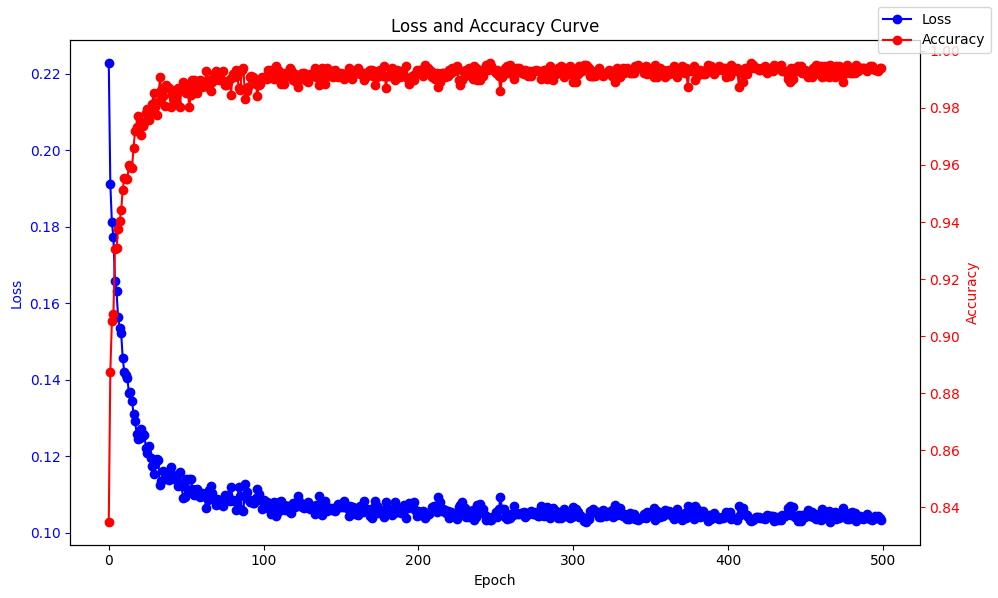

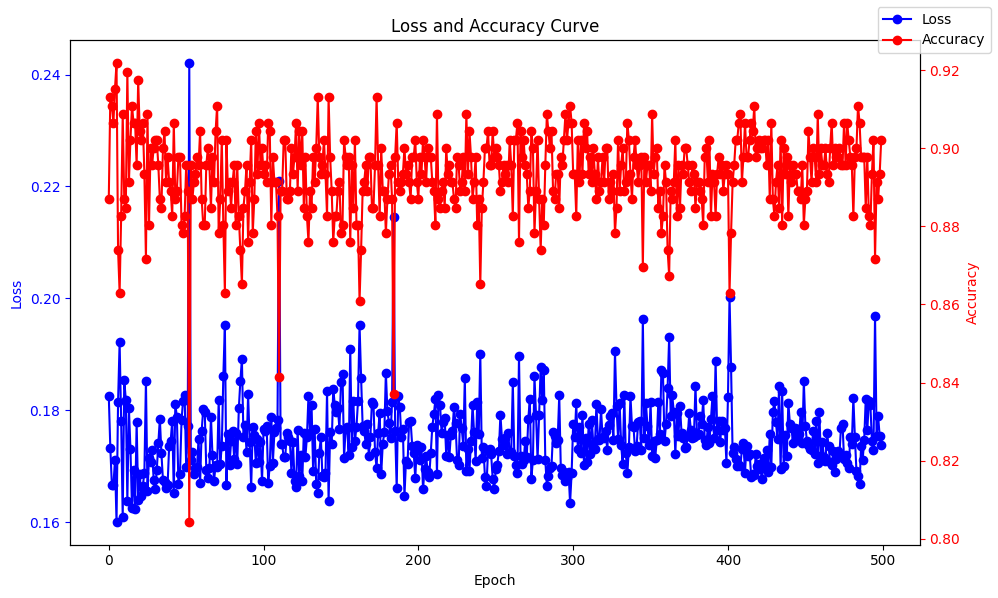

In [85]:
def plot_loss_acc_curve(filename):
    epochs, losses, accs = [], [], []

    with open(filename, 'r') as file:
        for line in file:
            parts = line.strip().split()
            epoch, loss, acc = int(parts[0]), float(parts[1]), float(parts[2])
            epochs.append(epoch)
            losses.append(loss)
            accs.append(acc)

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot Loss on the left y-axis
    ax1.plot(epochs, losses, marker='o', linestyle='-', color='b', label='Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='b')
    ax1.tick_params('y', colors='b')
    
    # Create a second y-axis for accuracy
    ax2 = ax1.twinx()
    ax2.plot(epochs, accs, marker='o', linestyle='-', color='r', label='Accuracy')
    ax2.set_ylabel('Accuracy', color='r')
    ax2.tick_params('y', colors='r')

    plt.title('Loss and Accuracy Curve')
    fig.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

# Usage
plot_loss_acc_curve('cnn_train_log.txt')

#because of mini batch reasons, the validation plot is not smooth
plot_loss_acc_curve('cnn_validation_log.txt')